In [87]:
import numpy as np
import libpysal as ps
import missingno as msno
import seaborn as sns
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
import seaborn as sns
import warnings
from mgwr.utils import shift_colormap, truncate_colormap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from numpy import dot 
from numpy.linalg import norm
from libpysal.weights.contiguity import Queen
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats

mpl.rcParams['axes.unicode_minus'] = False
warnings.simplefilter('ignore')

font_path = r'C:/Users/user/NanumFontSetup_TTF_ALL/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=18).get_name()
rc('font',family=font_name)

# 1. Data Load

In [3]:
data_path = '../data/fixed_dataset.csv'
data = pd.read_csv(data_path,encoding='euc-kr')
data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,외식업종다양성,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말 비율,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,점포밀도,(주거인구+직장인구)/유동인구,주거인구/직장인구
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,152.307733,...,0.362211,0.000000,1.452044,47.085413,2.342449,2.695669,31337.73585,1759.373944,0.303313,0.299127
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,159.363582,...,0.000000,0.000000,0.897946,140.443637,2.315147,2.280277,344640.00000,421.947013,0.356950,1.335893
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,107.510681,...,0.676952,1.987594,1.634245,472.189194,2.064957,2.339853,174949.46240,625.880521,0.324642,1.798850
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,0.000000,0.000000,0.000000,7.388826,2.273528,2.246297,97041.79104,461.266314,0.201775,12.617228
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,172.605265,...,0.683456,1.821731,1.648992,1786.712858,2.016228,2.004099,166589.33650,1660.729601,0.354007,3.918781


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               158 non-null    int64  
 1   BAS_AR               158 non-null    float64
 2   도로길이고려_전체통합도         158 non-null    float64
 3   도로길이고려_국부통합도_R3      158 non-null    float64
 4   기초구역평균_전체통합도         158 non-null    float64
 5   기초구역평균_국부통합도_R3      158 non-null    float64
 6   도로율                  158 non-null    float64
 7   평균 도로 길이             158 non-null    float64
 8   아파트시세변화_차분평균         158 non-null    float64
 9   평균영업기간               158 non-null    float64
 10  평균폐업기간               158 non-null    float64
 11  평균최근접역거리             158 non-null    float64
 12  평균최근접정류장거리           158 non-null    float64
 13  건물노후도                158 non-null    float64
 14  공동주택 연면적 비율          158 non-null    float64
 15  근린생활시설 연면적 비율        158 non-null    flo

## 1.1 결측치 확인

In [4]:
data.isnull().sum()

BAS_ID                 0
BAS_AR                 0
INT_LOAD               0
INT_LOAD_R3            0
INT_BAS                0
INT_BAS_R3             0
도로율                    0
평균 도로 길이               0
APART_DIFF_AVG         0
평균영업기간                 2
평균폐업기간                 9
평균최근접역거리               2
평균최근접정류장거리             2
건물노후도                  0
공동주택 연면적 비율            0
근린생활시설 연면적 비율          0
단독주택 연면적 비율            0
아파트 가구수                0
외식업매출월평균변화량            1
서비스업매출월평균변화량           1
소매업매출월평균변화량            1
외식업매출비율                1
서비스업매출비율               1
소매업매출비율                1
외식업종다양성                2
서비스업종다양성               2
소매업종다양성                2
상가밀도                   2
주중 / 주말 비율             0
06 to 18 / 18 to 06    0
BUILD_DIFF_AVG         0
점포밀도                   1
(주거인구+직장인구)/유동인구       0
주거인구/직장인구              0
x                      0
y                      0
dtype: int64

### 1.1.1 평균운영기간, 평균폐업기간
- 영업기간, 폐업기간 둘 다 없을 경우 제거
- 영업기간은 있지만 폐업기간이 없을 경우 영업기간으로 대체
- 점포밀도가 무한대인 row 제거

In [5]:
data[data['평균폐업기간'].isnull()][['BAS_ID','평균영업기간','평균폐업기간','점포밀도']]

,BAS_ID,평균영업기간,평균폐업기간,점포밀도
22,21322,201.466149,NaN,6.800084e+02
27,21327,89.858108,NaN,5.592935e+02
72,21372,NaN,NaN,0.000000e+00
73,21373,218.081333,NaN,2.198403e+02
75,21375,113.612189,NaN,inf
81,21381,183.029083,NaN,3.015351e+01
86,21386,116.766258,NaN,4.143950e+03
159,21459,165.177930,NaN,1.320829e+04
160,21460,NaN,NaN,NaN


In [6]:
# 제거할 row 정의 및 제거

drop_index = list(data[data['평균영업기간'].isnull()].index)
drop_index.append(75)

clean_data = data.drop(drop_index,axis=0).reset_index(drop=True)

In [7]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               158 non-null    int64  
 1   BAS_AR               158 non-null    float64
 2   INT_LOAD             158 non-null    float64
 3   INT_LOAD_R3          158 non-null    float64
 4   INT_BAS              158 non-null    float64
 5   INT_BAS_R3           158 non-null    float64
 6   도로율                  158 non-null    float64
 7   평균 도로 길이             158 non-null    float64
 8   APART_DIFF_AVG       158 non-null    float64
 9   평균영업기간               158 non-null    float64
 10  평균폐업기간               152 non-null    float64
 11  평균최근접역거리             158 non-null    float64
 12  평균최근접정류장거리           158 non-null    float64
 13  건물노후도                158 non-null    float64
 14  공동주택 연면적 비율          158 non-null    float64
 15  근린생활시설 연면적 비율        158 non-null    flo

In [8]:
# 평균폐업기간 null값 평균영업기간으로 대체

null_data_index = list(clean_data[clean_data['평균폐업기간'].isnull()].index)

for idx in null_data_index:
    clean_data.iloc[idx,10] = clean_data.iloc[idx,9]

In [9]:
# null값은 없다.
clean_data.isnull().sum()

BAS_ID                 0
BAS_AR                 0
INT_LOAD               0
INT_LOAD_R3            0
INT_BAS                0
INT_BAS_R3             0
도로율                    0
평균 도로 길이               0
APART_DIFF_AVG         0
평균영업기간                 0
평균폐업기간                 0
평균최근접역거리               0
평균최근접정류장거리             0
건물노후도                  0
공동주택 연면적 비율            0
근린생활시설 연면적 비율          0
단독주택 연면적 비율            0
아파트 가구수                0
외식업매출월평균변화량            0
서비스업매출월평균변화량           0
소매업매출월평균변화량            0
외식업매출비율                0
서비스업매출비율               0
소매업매출비율                0
외식업종다양성                0
서비스업종다양성               0
소매업종다양성                0
상가밀도                   0
주중 / 주말 비율             0
06 to 18 / 18 to 06    0
BUILD_DIFF_AVG         0
점포밀도                   0
(주거인구+직장인구)/유동인구       0
주거인구/직장인구              0
x                      0
y                      0
dtype: int64

In [10]:
temp_pos = pd.DataFrame.from_dict({'x':clean_data['x'],'y':clean_data['y']})

## 1.2 geometry 정보 로딩

In [5]:
basis_area= gpd.read_file('../data/전처리 파일/부평구_기초구역_5181/부평구_기초구역_4326.shp')
basis_area.head()

,BAS_AR,BAS_ID,BAS_MGT_SN,CTP_KOR_NM,MVMN_DE,MVMN_RESN,NTFC_DE,OPERT_DE,SIG_CD,SIG_KOR_NM,center_x,center_y,geometry
0,2.648838,21459,2823700025,인천광역시,None,None,20121221,None,28237,부평구,126.742914,37.474121,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,0.156212,21384,2823700061,인천광역시,None,None,20121221,None,28237,부평구,126.708049,37.489905,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,0.076024,21403,2823700058,인천광역시,None,None,20121221,None,28237,부평구,126.732706,37.489535,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,0.527205,21447,2823700035,인천광역시,None,None,20121221,None,28237,부평구,126.694834,37.482046,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,0.073898,21421,2823700036,인천광역시,None,None,20121221,None,28237,부평구,126.737058,37.484080,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."


In [6]:
use_basis_area = basis_area[['BAS_ID','geometry']]
use_basis_area

,BAS_ID,geometry
0,21459,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,21384,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,21403,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,21447,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,21421,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."
...,...,...
156,21423,"POLYGON ((126.73624 37.48294, 126.73641 37.482..."
157,21441,"POLYGON ((126.70483 37.48126, 126.70465 37.481..."
158,21446,"POLYGON ((126.70290 37.47138, 126.70289 37.471..."
159,21453,"POLYGON ((126.70070 37.46956, 126.70069 37.469..."


In [7]:
use_basis_area.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
clean_data = data
clean_data['BAS_ID'] = clean_data['BAS_ID'].astype(str) # string 티입으로 변환
clean_data = clean_data.merge(use_basis_area,how='left',right_on='BAS_ID',left_on='BAS_ID').sort_values(by='BAS_ID')
clean_data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말 비율,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,점포밀도,(주거인구+직장인구)/유동인구,주거인구/직장인구,geometry
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,152.307733,...,0.000000,1.452044,47.085413,2.342449,2.695669,31337.73585,1759.373944,0.303313,0.299127,"POLYGON ((126.69032 37.52345, 126.69084 37.523..."
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,159.363582,...,0.000000,0.897946,140.443637,2.315147,2.280277,344640.00000,421.947013,0.356950,1.335893,"POLYGON ((126.69791 37.52246, 126.69791 37.522..."
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,107.510681,...,1.987594,1.634245,472.189194,2.064957,2.339853,174949.46240,625.880521,0.324642,1.798850,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,0.000000,0.000000,7.388826,2.273528,2.246297,97041.79104,461.266314,0.201775,12.617228,"POLYGON ((126.70215 37.51767, 126.70204 37.517..."
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,172.605265,...,1.821731,1.648992,1786.712858,2.016228,2.004099,166589.33650,1660.729601,0.354007,3.918781,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."


In [10]:
center = gpd.GeoDataFrame(clean_data).centroid

clean_data['x'] = center.x
clean_data['y'] = center.y

clean_data.iloc[:,-3:]

,geometry,x,y
0,"POLYGON ((126.69032 37.52345, 126.69084 37.523...",126.689135,37.518708
1,"POLYGON ((126.69791 37.52246, 126.69791 37.522...",126.695459,37.522417
2,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.701342,37.522339
3,"POLYGON ((126.70215 37.51767, 126.70204 37.517...",126.698730,37.518981
4,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.703419,37.519319
...,...,...,...
153,"POLYGON ((126.69459 37.47098, 126.69442 37.470...",126.692372,37.471208
154,"POLYGON ((126.72120 37.48069, 126.72130 37.480...",126.723687,37.476074
155,"POLYGON ((126.75185 37.48111, 126.75174 37.480...",126.749377,37.478546
156,"POLYGON ((126.73533 37.48512, 126.73537 37.485...",126.731154,37.483105


In [ ]:
## 1.3

# 2. 공간상관성 검증
- H0 : 군집이 존재하지 않는다. 즉, 모든 구역이 Randomness를 가진다.(AutoCorrelation이 없다.)
- 유의 수준 : 0.05
- 검정통계량 : Morans'I

In [20]:
ind_var_col = list(range(1,9)) + list(range(11,35))

gdf = clean_data.iloc[:,ind_var_col]
y = clean_data['평균폐업기간'].values

In [21]:
w = Queen.from_dataframe(gdf)
w.transform = 'r'

In [22]:
# Assessing Global Spatial Autocorrelation
# calculate Morans'I. 
w = Queen.from_dataframe(gdf)
moran = Moran(y, w)
moran.I

0.12943364044826547

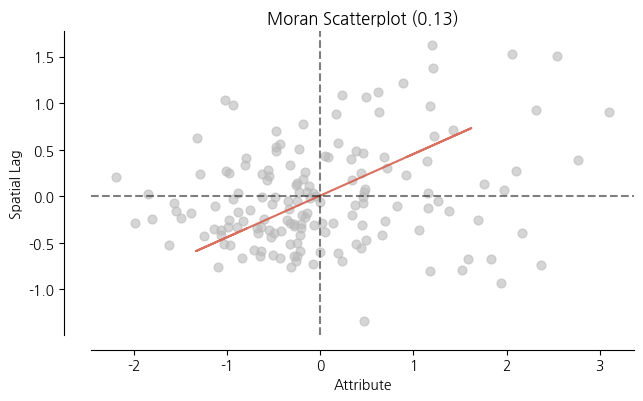

In [23]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

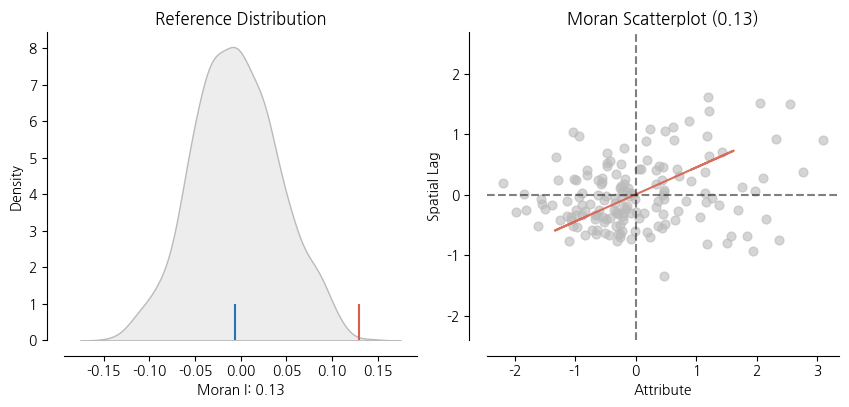

In [24]:
from splot.esda import plot_moran

plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

In [25]:
moran.p_sim

0.002

- p-value가 0.002이므로 유의수준 5%이내에서 전역적으로 보았을 때 군집이 존재하다고 이야기 할수 있다.

# 3. LISA 검정
- 왜 국지적 모델(GWR)을 써야하는가?
- Morans'I를 통해서 공간적 의존성은 확인할 수 있으나 공간적 이질성은 확인할 수가 없다.
- 공간적 의존성 : 공간상의 한 지점에서 측정된 현상이 다른 지점에서의 측정값과 서로 관련이 있을 때 나타난다.
- 공간적 이질성 : 각 지점이나 지역에 내재된 고유성에서 발생하게 되는 자료의 지리적 변이나 통계적 특성의 차이를 말한다.
- LISA 검정을 통해서 공간적 이질성이 존재하는지 확인해본다.
- H0 : 특정지역별로 공간적 군집이 형성되지 않는다.
- 유의 수준 : 0.05

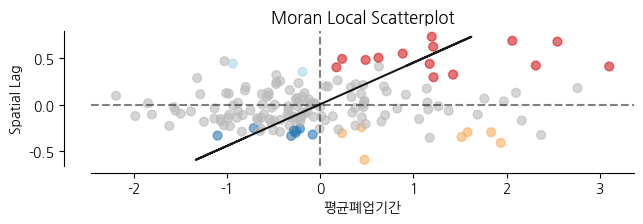

In [26]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
lisa = Moran_Local(y, w)
fig, ax = moran_scatterplot(lisa, p=0.05)
ax.set_xlabel('평균폐업기간')
ax.set_ylabel('Spatial Lag')
plt.show()

In [27]:
sig = lisa.p_sim < 0.05
sig.sum()

31

In [28]:
hotspots = lisa.q==1 * sig
hotspots.sum()

14

In [29]:
# HH Area
clean_data[hotspots]

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,상가밀도,주중 / 주말 비율,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,점포밀도,(주거인구+직장인구)/유동인구,주거인구/직장인구,geometry,x,y
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.00000,152.307733,...,47.085413,2.342449,2.695669,31337.73585,1759.373944,0.303313,0.299127,"POLYGON ((126.69032 37.52345, 126.69084 37.523...",126.689135,37.518708
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.90900,159.363582,...,140.443637,2.315147,2.280277,344640.00000,421.947013,0.356950,1.335893,"POLYGON ((126.69791 37.52246, 126.69791 37.522...",126.695459,37.522417
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.50000,153.728003,...,7.388826,2.273528,2.246297,97041.79104,461.266314,0.201775,12.617228,"POLYGON ((126.70215 37.51767, 126.70204 37.517...",126.698730,37.518981
5,21305,0.098059,523.710848,6145.133162,0.095792,1.100614,38.069916,106.077128,0.00000,179.564066,...,856.627133,2.048316,1.997069,69414.52880,4566.907644,0.376629,4.180348,"POLYGON ((126.70432 37.51753, 126.70426 37.517...",126.703004,37.515329
6,21306,0.284578,649.381963,7939.781286,0.087015,1.078935,12.802792,117.955382,1753.75000,145.382862,...,66.765527,1.953813,2.429456,76053.06346,5882.780945,2.558570,49.280796,"POLYGON ((126.70215 37.51767, 126.70214 37.517...",126.697205,37.515679
7,21307,0.616604,589.273284,7121.372418,0.089115,1.069964,6.382154,119.324019,458.70125,124.831374,...,105.416118,1.944366,2.252227,56452.17391,720.266044,1.727312,17.421429,"POLYGON ((126.70164 37.51321, 126.70165 37.513...",126.693100,37.512529
8,21308,0.229900,421.903482,5071.581658,0.093441,1.153545,9.134493,156.407455,0.00000,171.724749,...,73.945194,2.262532,1.770196,67064.35185,406.738655,1.835686,19.015844,"POLYGON ((126.69275 37.51095, 126.69369 37.510...",126.694636,37.509724
9,21309,0.102131,342.128741,4248.872704,0.098518,1.144899,33.748921,149.365524,1716.71400,131.415793,...,773.516366,2.146131,1.985019,77593.49776,1010.378351,0.438911,8.377488,"POLYGON ((126.70394 37.51300, 126.70393 37.512...",126.702572,37.510880
67,21367,0.228448,433.242790,5042.136816,0.094212,1.099477,23.912363,125.875000,168.32500,177.378043,...,26.264183,2.244106,1.861148,86329.74684,164.718929,1.998314,52.758156,"POLYGON ((126.69990 37.50892, 126.69990 37.508...",126.696109,37.507611
68,21368,0.218311,302.074763,3370.850035,0.088329,1.013514,5.180353,79.951000,-172.09800,138.682993,...,59.548076,2.227330,1.885386,98608.75000,185.571481,0.583356,15.421209,"POLYGON ((126.69505 37.50601, 126.69556 37.505...",126.692740,37.505831


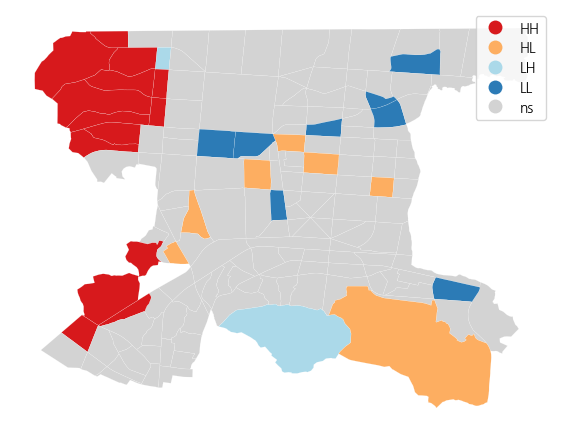

In [30]:
from splot.esda import lisa_cluster

gdf = gpd.GeoDataFrame(gdf)

lisa_cluster(lisa, gdf, p=0.05, figsize = (7,7))
plt.show()

- 총 13곳의 hotspot이 존재한다. 따라서 공간적 이질성을 가진다고 판단할 수 있고, GWR 모델을 고려해야 한다.

# 4. OLS

## 4.1 독립변수, 종속변수 설정

In [31]:
import statsmodels.api as sm

In [40]:
ind_var_col = list(range(1,9)) + list(range(11,34))

X = clean_data.iloc[:,ind_var_col].values
X = sm.add_constant(X)
y = clean_data.loc[:,'평균폐업기간'].values

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     3.643
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           1.90e-07
Time:                        09:13:22   Log-Likelihood:                -767.60
No. Observations:                 158   AIC:                             1597.
Df Residuals:                     127   BIC:                             1692.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.7442     60.423      0.873      0.384     -66.822     172.311
x1            18.9689     17.635      1.076      0.284     -15.928      53.866
x2             0.0164      0.091      0.180      0.857      -0.164       0.197
x3             0.0030      0.008      0.395      0.694      -0.012       0.018
x4          -155.8513    389.521     -0.400      0.690    -926.643     614.940
x5            18.3903     58.203      0.316      0.753     -96.783     133.564
x6            -1.0435      0.360     -2.896      0.004      -1.757      -0.330
x7            -0.1042      0.054     -1.936      0.055      -0.211       0.002
x8            -0.0084      0.005     -1.778      0.078      -0.018       0.001
x9             2.8784      7.982      0.361      0.719     -12.916      18.673
x10         -291.6375     86.813     -3.359      0.001    -463.425    -119.850
x11            0.1013      0.048      2.120      0.036       0.007       0.196
x12           -0.0518      0.190     -0.272      0.786      -0.429       0.325
x13            0.1010      0.232      0.435      0.664      -0.358       0.560
x14           -0.2310      0.249     -0.927      0.356      -0.724       0.262
x15           -0.0080      0.004     -2.075      0.040      -0.016      -0.000
x16         6.846e-08   1.23e-07      0.558      0.578   -1.74e-07    3.11e-07
x17         1.884e-07   1.77e-07      1.061      0.291   -1.63e-07     5.4e-07
x18         9.951e-08   8.63e-08      1.153      0.251   -7.12e-08     2.7e-07
x19           78.4820     37.143      2.113      0.037       4.983     151.981
x20          -36.6292     38.265     -0.957      0.340    -112.349      39.091
x21           10.8913     28.708      0.379      0.705     -45.918      67.700
x22            0.8181     14.273      0.057      0.954     -27.426      29.062
x23          -11.9195      7.303     -1.632      0.105     -26.372       2.533
x24          -10.8971      9.352     -1.165      0.246     -29.403       7.609
x25           -0.0011      0.005     -0.217      0.828      -0.011       0.009
x26           20.3975     29.216      0.698      0.486     -37.415      78.210
x27           17.1163     13.844      1.236      0.219     -10.279      44.512
x28         3.013e-05    5.3e-05      0.568      0.571   -7.47e-05       0.000
x29           -0.0002      0.000     -0.808      0.421      -0.001       0.000
x30           13.2518      7.793      1.700      0.092      -2.170      28.674
x31            0.0598      0.077      0.781      0.437      -0.092       0.211
==============================================================================
Omnibus:                        4.308   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.116   Jarque-Bera (JB):                4.564
Skew:                           0.203   Prob(JB):                        0.102
Ku

## 4.2 Modeling

### 4.2.1 다중공선성

In [33]:
def check_vif(dX):
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(dX.values,i) for i in range(dX.values.shape[1])] 
    vif['features'] = dX.columns
    vif = vif.sort_values("VIF Factor").reset_index(drop=True)
    
    return vif

result = check_vif(clean_data.iloc[:,ind_var_col])
result.iloc[-20:,]

,VIF Factor,features
11,2.406673,아파트 가구수
12,2.527795,평균최근접정류장거리
13,2.572431,평균 도로 길이
14,2.648532,개별공시지가 변화 차분평균
15,2.687791,BAS_AR
16,2.835141,도로율
17,2.851667,단독주택 연면적 비율
18,3.162057,기초구역평균_국부통합도_R3
19,3.181838,서비스업종다양성
20,3.222415,06 to 18 / 18 to 06


#### 4.2.1.2 column 제거

In [34]:
dX = clean_data.iloc[:,ind_var_col]

def RFE(df):
    flag = True
    next_col = list(dX.columns)
    
    while flag:
        local = df.loc[:,next_col]
        result = check_vif(local)

        if len(result[result['VIF Factor'] > 10]) == 0:
            return result # 유일한 탈출 조건
        
        next_col = result.iloc[:-1,1].values.tolist()
        
vif_result = RFE(dX)
optimal_feature = vif_result['features'].values.tolist()
optimal_feature

['아파트시세변화_차분평균',
 '점포밀도',
 '서비스업매출월평균변화량',
 '주거인구/직장인구',
 '소매업매출월평균변화량',
 '외식업매출월평균변화량',
 '단독주택 연면적 비율',
 '아파트 가구수',
 'BAS_AR',
 '상가밀도',
 '근린생활시설 연면적 비율',
 '개별공시지가 변화 차분평균',
 '(주거인구+직장인구)/유동인구',
 '평균최근접역거리',
 '도로길이고려_국부통합도_R3',
 '평균 도로 길이',
 '외식업종다양성',
 '평균최근접정류장거리',
 '공동주택 연면적 비율']

#### 4.2.1.3 Remodeling


In [57]:
X = clean_data.loc[:,optimal_feature].values
X = sm.add_constant(X)

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     3.331
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           2.19e-05
Time:                        09:20:51   Log-Likelihood:                -786.82
No. Observations:                 158   AIC:                             1614.
Df Residuals:                     138   BIC:                             1675.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        122.7624     23.675      5.185      0.000      75.949     169.575
x1            -0.0075      0.005     -1.540      0.126      -0.017       0.002
x2            -0.0003      0.000     -0.896      0.372      -0.001       0.000
x3          6.439e-08   1.88e-07      0.342      0.733   -3.08e-07    4.36e-07
x4             0.0243      0.077      0.315      0.753      -0.128       0.177
x5          4.287e-08    8.9e-08      0.481      0.631   -1.33e-07    2.19e-07
x6          3.234e-08   1.28e-07      0.254      0.800    -2.2e-07    2.85e-07
x7            -0.1413      0.253     -0.559      0.577      -0.641       0.359
x8            -0.0123      0.004     -3.169      0.002      -0.020      -0.005
x9            38.7603     16.665      2.326      0.021       5.808      71.713
x10           -0.0088      0.005     -1.882      0.062      -0.018       0.000
x11            0.2282      0.235      0.972      0.333      -0.236       0.692
x12          1.33e-05   5.12e-05      0.260      0.795   -8.79e-05       0.000
x13           11.9850      8.159      1.469      0.144      -4.148      28.118
x14            9.8936      7.664      1.291      0.199      -5.260      25.047
x15            0.0026      0.002      1.544      0.125      -0.001       0.006
x16           -0.1134      0.048     -2.360      0.020      -0.208      -0.018
x17          -18.9641     12.748     -1.488      0.139     -44.171       6.243
x18         -183.3146     79.908     -2.294      0.023    -341.317     -25.312
x19            0.0968      0.196      0.494      0.622      -0.291       0.484
==============================================================================
Omnibus:                        4.589   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.101   Jarque-Bera (JB):                4.145
Skew:                           0.328   Prob(JB):                        0.126
Kurtosis:                       3.446   Cond. No.                     1.37e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.2.2 잔차분석
- 회귀모형에 대한 가정(정규성, 등분산성, 독립성)을 충족하는지에 대한 검정, 이상치가 개입하는지에 대한 검정을 하는 절차

In [41]:
import scipy as sp
from scipy import stats

#### 4.2.2.1 잔차 정규성

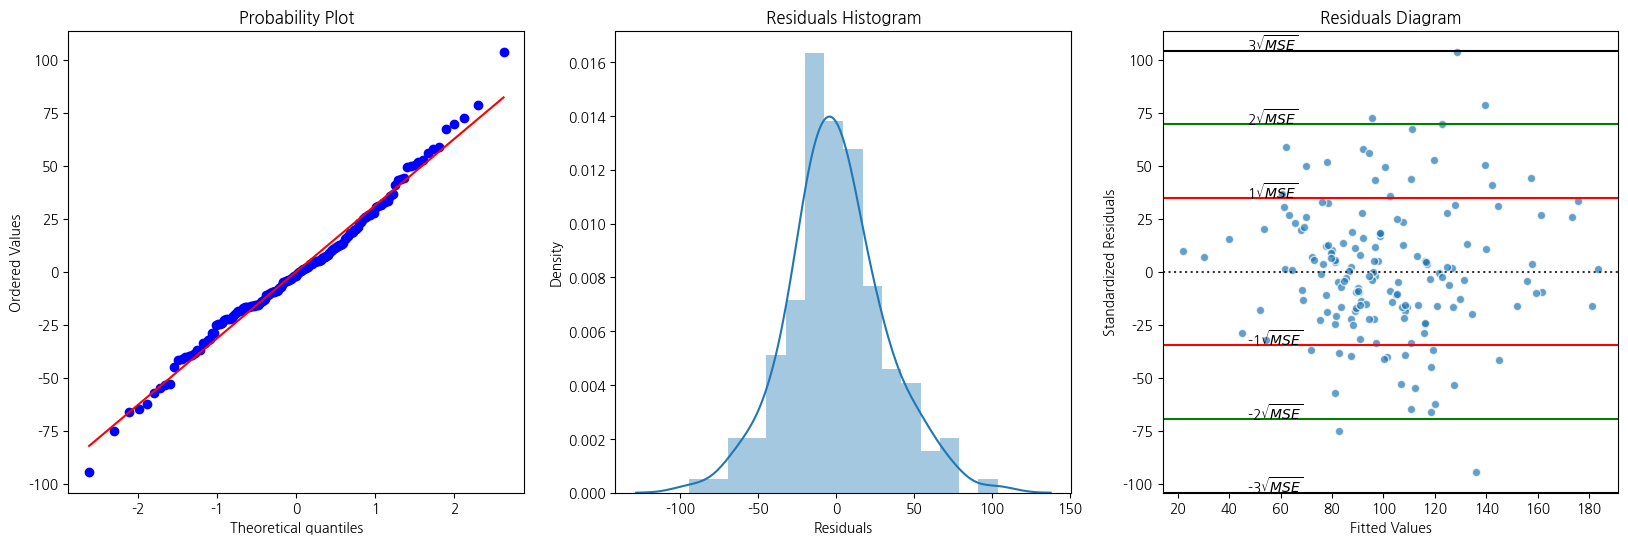

In [42]:
figure, axs = plt.subplots(1,3, figsize = (20,6))

# 잔차 Q-Q  plot
# sm.ProbPlot(fit1.resid).qqplot(line="s",ax=axs[0])
sp.stats.probplot(results.resid, dist='norm', fit=True, plot=axs[0])

# 잔차의 히스토그램
sns.distplot(x = results.resid , ax = axs[1])
axs[1].set_xlabel("Residuals")
axs[1].set_title("Residuals Histogram")

# 잔차도 MSE 라인
yhat = pd.DataFrame(results.fittedvalues)
temp = pd.concat([yhat,clean_data.loc[:,'평균폐업기간']],axis=1)
temp.columns = ['yhat','MEDV']

sns.residplot(x='yhat',y='MEDV',data=temp, scatter_kws = {'edgecolor':"white", "alpha":0.7}, line_kws = {"color":"red"})
MSE_sq = np.sqrt(results.mse_resid) #RMSE

# 잔차도 MSE line
for i, c in enumerate(["red", "green", "black"]):
    axs[2].axhline( (i+1) * MSE_sq, color = c)
    axs[2].axhline( -(i+1) * MSE_sq, color = c)
    
    axs[2].text(47, (i+1) * MSE_sq, f"{i+1}"r'${}\sqrt{MSE}$')
    axs[2].text(47, -(i+1) * MSE_sq, f"-{i+1}"r'${}\sqrt{MSE}$')

axs[2].set_xlabel("Fitted Values")
axs[2].set_ylabel("Standardized Residuals")
axs[2].set_title("Residuals Diagram")

plt.show()

In [43]:
test = stats.shapiro(results.resid)
print('검정통계량 : {0}\np-value : {1}'.format(test[0],test[1]))

# 유의수준 0.05에서 귀무가설을 기각할 수 없다.
# 따라서 정규성을 띈다고 말할 수 있다.

검정통계량 : 0.9886830449104309
p-value : 0.2336270958185196


#### 4.2.2.2 잔차 등분산성
- 종속 변수의 값의 분산이 독립 변수의 값과 상관없이 고정된 값을 가져야 한다.
- 실제 데이터는 독립 변수 값의 크기가 커지면 종속 변수 값의 분산도 커지는 이분산성 문제가 발생한다.

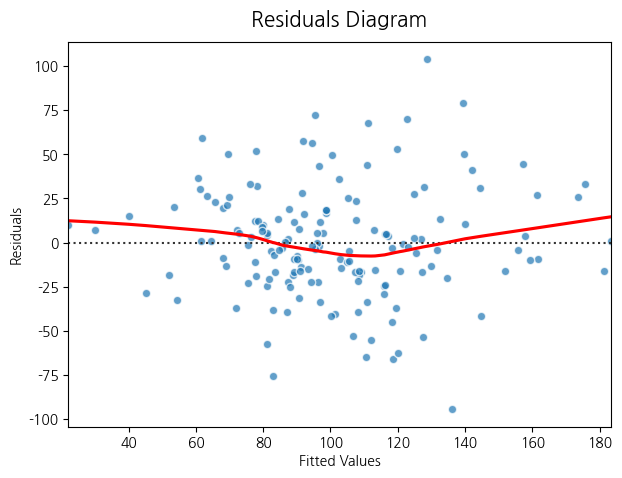

In [44]:
fig = plt.figure(figsize= (7,5))

p = sns.residplot(x = "yhat", y = "MEDV", 
                  data = temp, 
                  scatter_kws = {'edgecolor':"white", "alpha":0.7},
                  lowess = True,
              line_kws = {"color":"red"})

p.set_title("Residuals Diagram", fontsize=15, y=1.02)
p.set(xlabel= "Fitted Values", ylabel = "Residuals")

plt.show()

In [45]:
from sklearn.linear_model import LinearRegression
from scipy.stats import chisqprob


def breusch_pagan_test(x, y):
    '''
    Breusch-Pagan test for heteroskedasticity in a linear regression model:
    H_0 = No heteroskedasticity.
    H_1 = Heteroskedasticity is present.

    Inputs:
    x = a numpy.ndarray containing the predictor variables. Shape = (nSamples, nPredictors).
    y = a 1D numpy.ndarray containing the response variable. Shape = (nSamples, ).

    Outputs a list containing three elements:
    1. the Breusch-Pagan test statistic.
    2. the p-value for the test.
    3. the test result.
    '''

    if y.ndim != 1:
        raise SystemExit('Error: y has more than 1 dimension.')
    if x.shape[0] != y.shape[0]:
        raise SystemExit('Error: the number of samples differs between x and y.')
    else:
        n_samples = y.shape[0]

    # fit an OLS linear model to y using x:
    lm = LinearRegression()
    lm.fit(x, y)

    # calculate the squared errors:
    err = (y - lm.predict(x))**2

    # fit an auxiliary regression to the squared errors:
    # why?: to estimate the variance in err explained by x
    lm.fit(x, err)
    pred_err = lm.predict(x)
    del lm

    # calculate the coefficient of determination:
    ss_tot = sum((err - np.mean(err))**2)
    ss_res = sum((err - pred_err)**2)
    r2 = 1 - (ss_res / ss_tot)
    del err, pred_err, ss_res, ss_tot

    # calculate the Lagrange multiplier:
    LM = n_samples * r2
    del r2

    # calculate p-value. degrees of freedom = number of predictors.
    # this is equivalent to (p - 1) parameter restrictions in Wikipedia entry.
    pval = chisqprob(LM, x.shape[1])

    if pval < 0.01:
        test_result = 'Heteroskedasticity present at 99% CI.'
    elif pval < 0.05:
        test_result = 'Heteroskedasticity present at 95% CI.'
    else:
        test_result = 'No significant heteroskedasticity.'
    return [LM, pval, test_result]

tX = clean_data.iloc[:,ind_var_col]
ty = clean_data.loc[:,'평균영업기간']

result = breusch_pagan_test(tX,ty)
print('LM : {}\np-value : {}\ntest_result {}'.format(result[0],result[1],result[2]))

# p-value가 0.05보다 크므로 귀무가설을 기각할 수 없다. 따라서 등분산성을 만족한다고 할수 있다.

LM : 35.276337233352166
p-value : 0.2729802187560926
test_result No significant heteroskedasticity.


#### 4.2.2.3 잔차 독립성

In [46]:
from statsmodels.stats.stattools import durbin_watson

print(f"D-W 통계량: {round(durbin_watson(results.resid),3)}")

# 통계량이 1.5~2.5 사이이므로 잔차들이 자기상관성을 가지고 있지 않다. 따라서 독립성을 만족한다.

D-W 통계량: 1.975


### 4.2.3 PCA

In [47]:
# Scaling
dX_scaled = StandardScaler().fit_transform(dX.values)
std_df = pd.DataFrame(dX_scaled, index=dX.index, columns=dX.columns)

# PCA
pca = PCA(n_components=len(dX.columns))
pca_array = pca.fit_transform(std_df)
pca_df = pd.DataFrame(pca_array, index=dX.index,
                      columns=[f"pca{num+1}" for num in range(dX.shape[1])])
pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31
0,-3.613134,3.530900,2.724283,0.276752,-1.265335,0.222535,-1.249258,0.254725,-1.211915,-1.413451,...,0.149124,0.426784,0.634356,0.088219,-0.099155,0.778499,-0.372378,0.026139,-0.059482,4.982571e-10
1,-3.716310,0.848623,-0.064141,-0.571030,-2.226301,1.216343,2.213785,-1.198736,-1.189780,0.118728,...,-0.986655,0.178153,0.004975,1.010222,0.090495,-0.225068,0.663023,-0.919879,-0.099331,-2.724820e-09
2,-0.365597,1.475587,0.642787,1.128603,-0.802873,2.174929,0.027581,1.234037,-0.919316,-3.048760,...,-0.919845,-0.138896,0.637881,-0.304021,-0.147966,-0.630090,-0.350852,0.531900,-0.096412,-1.355014e-09
3,-2.969321,3.012788,1.708687,-1.227990,2.124193,-0.764408,0.224814,-0.064627,-0.121116,1.179473,...,0.028366,0.201424,-0.859281,0.355405,0.949311,-0.624679,-0.558865,-0.111747,-0.081367,1.346316e-09
4,1.407811,1.356113,0.162097,-0.520044,1.229472,0.407270,0.673102,-0.453810,1.623636,-0.363839,...,0.409022,-0.201229,0.072320,0.250466,-0.201922,-0.316505,-0.187055,-0.122410,0.070251,-4.647120e-09


In [48]:
# 고윳값과 누적기여율 계산

result = pd.DataFrame({'고윳값':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(dX.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

,고윳값,기여율,누적기여율
pca1,4.961290e+00,1.590287e-01,0.159029
pca2,3.699891e+00,1.185959e-01,0.277625
pca3,2.839880e+00,9.102923e-02,0.368654
pca4,2.212110e+00,7.090676e-02,0.439561
pca5,2.056751e+00,6.592688e-02,0.505488
pca6,1.673020e+00,5.362682e-02,0.559114
pca7,1.504580e+00,4.822765e-02,0.607342
pca8,1.369114e+00,4.388543e-02,0.651227
pca9,1.285336e+00,4.120003e-02,0.692427
pca10,1.099209e+00,3.523393e-02,0.727661


In [49]:
# 개별 고윳값 즉, 각 주성분 마다 고윳값이 0.7이상인 주성분들, 누적기여율이 80% 이상이 넘어거지는 지점까지의 
# 주성분들을 기준으로 하여 적절한 주성분 개수를 설정한다. 

condition = (result['고윳값'] >= 0.7) & (result['누적기여율'] >= 0.8)
pca_index = list(result[condition].reset_index().index)

In [50]:
pca_columns = list(dX.iloc[:,pca_index].columns)
pca_columns

['BAS_AR', '도로길이고려_전체통합도']

#### 4.2.3.1 Remodeling

In [52]:
X = dX.loc[:,pca_columns].values
X = sm.add_constant(X)

In [53]:
#Calibrate GWR model
# 평균영업기간

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.378
Date:                Fri, 05 Nov 2021   Prob (F-statistic):             0.0366
Time:                        09:19:05   Log-Likelihood:                -813.28
No. Observations:                 158   AIC:                             1633.
Df Residuals:                     155   BIC:                             1642.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         87.8429      7.666     11.459      0.000      72.700     102.986
x1            27.6454     13.291      2.080      0.039       1.391      53.899
x2             0.0220      0.020      1.093      0.276      -0.018       0.062
==============================================================================
Omnibus:                       10.761   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.946
Skew:                           0.615   Prob(JB):                      0.00420
Kurtosis:                       3.386   Cond. No.                     1.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.2.4 교차 검증

In [54]:
# 필요한 모듈 import
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [58]:
# 다중공선성이 있는 column들을 제거한 독립변수들을 사용함

train_scores = np.zeros(5)
test_scores = np.zeros(5)
train_rmse = np.zeros(5)
test_rmse = np.zeros(5)


cv = KFold(5, shuffle=True, random_state=0)

for i, (idx_train, idx_test) in enumerate(cv.split(X = X, y = y)):
    local_X_train, local_y_train = X[idx_train], y[idx_train]
    local_X_test, local_y_test = X[idx_test], y[idx_test]
    
    model = sm.OLS(local_y_train,local_X_train)
    result = model.fit()
    
    pred = result.predict(local_X_test)
    
    train_scores[i] = result.rsquared
    test_scores[i] = r2_score(local_y_test,pred)
    train_rmse[i] = np.sqrt(result.mse_model)
    test_rmse[i] = np.sqrt(mean_squared_error(local_y_test,pred))
    
    print('====================== FOLD {} ======================'.format(i))
    print('학습 RMSE : {:.8f}, 검증 RMSE : {:.8f}'.format(np.sqrt(result.mse_model),test_rmse[i]))
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, test_scores[i]))
    
print('\n===================== 평균 결과 ======================')
print('학습 평균 R2 : {:.8f}   검증 평균 R2 : {:.8f}'.format(train_scores.mean(),test_scores.mean()))
print('학습 평균 RMSE : {:.8f}   검증 평균 RMSE : {:.8f}'.format(train_rmse.mean(), test_rmse.mean()))

====================== FOLD 0 ======================
학습 RMSE : 70.07741432, 검증 RMSE : 37.02451134
학습 R2 = 0.37038086, 검증 R2 = -0.36339331
====================== FOLD 1 ======================
학습 RMSE : 61.85162511, 검증 RMSE : 40.49033454
학습 R2 = 0.32766866, 검증 R2 = 0.17234661
====================== FOLD 2 ======================
학습 RMSE : 63.25258214, 검증 RMSE : 50.10745058
학습 R2 = 0.34007730, 검증 R2 = -0.37321912
====================== FOLD 3 ======================
학습 RMSE : 65.45373202, 검증 RMSE : 45.15103329
학습 R2 = 0.32921384, 검증 R2 = -0.68348752
====================== FOLD 4 ======================
학습 RMSE : 56.78512642, 검증 RMSE : 47.12191805
학습 R2 = 0.31212280, 검증 R2 = 0.22722185

===================== 평균 결과 ======================
학습 평균 R2 : 0.33589269   검증 평균 R2 : -0.20410630
학습 평균 RMSE : 63.48409600   검증 평균 RMSE : 43.97904956


In [59]:
# 다중공선성이 있는 column들을 제거한 독립변수들을 사용함.

lr = LinearRegression()

kfold = KFold(n_splits=5, shuffle=True, random_state=140)
score = cross_val_score(lr, X, y, cv=kfold,scoring='r2')
print('교차 검증 점수 : ', score)
print('교차 검증 평균 점수 : ', score.mean())

교차 검증 점수 :  [ 0.08833438  0.12558437  0.03800767 -3.11306454  0.34010549]
교차 검증 평균 점수 :  -0.5042065261409826


# 5. XGBoost

## 5.1 교차검증

In [60]:
# test & train set 분리
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size = 0.2,random_state = 1010)

In [61]:
# XGBoost 모델에 쓰일 parameter 정의
n_splits= 5
NUM_BOOST_ROUND = 10000
SEED = 1993 
xgb_params={ 'booster':'gblinear',
         'verbosity':0,
         'silent':1,
         'num_boost_rounds':160,
         'min_child_weight':1,
         'max_depth':4,
         'early_stopping_rounds':50,
         'eta':0.1,
         'sub_sample':1,
         'eval_metric':'rmse',
}

In [62]:
# 다중공선성이 있는 column들을 제거한 독립변수들을 사용함
# OOF 방법을 사용함.

xgb_oof_train = np.zeros((X_train.shape[0],))
xgb_oof_test = np.zeros((X_test.shape[0],))

cv_list=[]

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1010, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = X_train, y = y_train ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train_f , y_train_f = X_train[trn_ind], y_train[trn_ind]
    X_valid , y_valid = X_train[val_ind], y_train[val_ind]
    
    # XGBoost
    print("---TRAINING XGBOOST--")
    dtrain = xgb.DMatrix(X_train_f,y_train_f)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    
    # model 정의 & 학습
    xgb_model = xgb.train(xgb_params,dtrain, NUM_BOOST_ROUND,
                     evals=[(dtrain,'train'),(dvalid,'valid')],
                        early_stopping_rounds=100,
                         verbose_eval=30)
    
    xgb_valid_pred = xgb_model.predict(dvalid)
    xgb_test_pred = xgb_model.predict(xgb.DMatrix(X_test,y_test))    
    
    cv_list.append(np.sqrt(mean_squared_error(y_valid,xgb_valid_pred)))
    
    xgb_oof_train[val_ind] = xgb_valid_pred
    xgb_oof_test += xgb_test_pred/n_splits
    print('='*80)

print(f"<LOCAL_TRAIN> OVERALL RMSE : {np.sqrt( mean_squared_error( y_train, xgb_oof_train ) )}")
print(f"<LOCAL_TEST>  OVERALL RMSE : {np.sqrt( mean_squared_error( y_test, xgb_oof_test ) )}")
print(f"<LOCAL_TRAIN> OVERALL R2 : {r2_score( y_train, xgb_oof_train ) }")
print(f"<LOCAL_TEST>  OVERALL R2 : {r2_score( y_test, xgb_oof_test ) }")

0it [00:00, ?it/s]

---TRAINING XGBOOST--
[0]	train-rmse:51.87162	valid-rmse:66.29596
[30]	train-rmse:36.75396	valid-rmse:48.85708
[60]	train-rmse:35.51351	valid-rmse:46.74657
[90]	train-rmse:34.80994	valid-rmse:45.77833
[120]	train-rmse:34.34253	valid-rmse:45.34700
[150]	train-rmse:34.00767	valid-rmse:45.19550
[180]	train-rmse:33.75550	valid-rmse:45.19352
[210]	train-rmse:33.55875	valid-rmse:45.30304
[240]	train-rmse:33.40292	valid-rmse:45.45662
[259]	train-rmse:33.31946	valid-rmse:45.55731
---TRAINING XGBOOST--
[0]	train-rmse:52.15750	valid-rmse:44.55595
[30]	train-rmse:39.64194	valid-rmse:38.06231
[60]	train-rmse:37.84162	valid-rmse:40.12687
[90]	train-rmse:36.94120	valid-rmse:42.12814
[110]	train-rmse:36.57554	valid-rmse:43.26422
---TRAINING XGBOOST--
[0]	train-rmse:55.82755	valid-rmse:45.49546
[30]	train-rmse:40.36762	valid-rmse:27.63549
[60]	train-rmse:38.83406	valid-rmse:26.82191
[90]	train-rmse:38.07526	valid-rmse:26.64721
[120]	train-rmse:37.61037	valid-rmse:26.71842
[150]	train-rmse:37.29457	val

# 5. 지리가중회귀분석(GWR)

## 5.1 독립변수, 종속변수 설정

In [75]:
ind_var_col = list(range(1,9)) + list(range(11,34))

s_y1 = clean_data['평균영업기간'].values.reshape((-1,1)) # 종속변수1
s_y2 = clean_data['평균폐업기간'].values.reshape((-1,1)) # 종속변수2

# 다중공선성 제거
s_X= clean_data.loc[:,optimal_feature].values

# Raw Data
# s_X = clean_data.iloc[:,ind_var_col].values

# 왜도 2이상인 데이터 log변환 후, standard scaling 함
# s_X= ss_scaled_dX.values


# 왜도 2이상인 데이터 log변환 후, standard scaling, 다중공선성 제거
# s_X= ss_scaled_dX.loc[:,optimal_feature].values
    
u = clean_data['x'] # 경도
v = clean_data['y'] # 위도
s_coords = list(zip(u,v))

s_X.shape

(158, 19)

### 5.2.1 종속변수 분포 확인


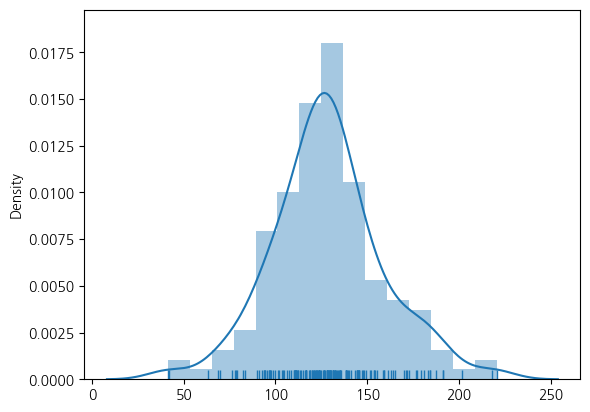

In [55]:
sns.distplot(s_y1,hist=True,kde=True,rug=True)
plt.show()

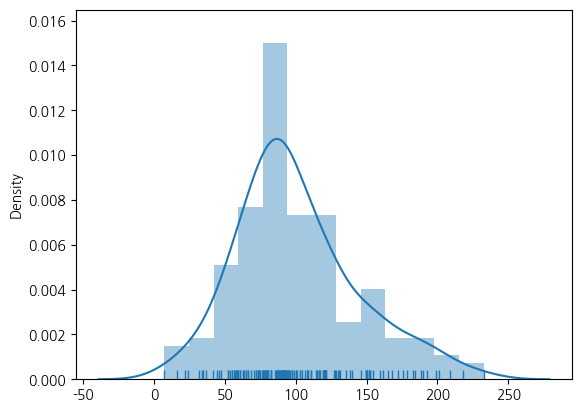

In [56]:
sns.distplot(s_y2,hist=True,kde=True,rug=True)
plt.show()

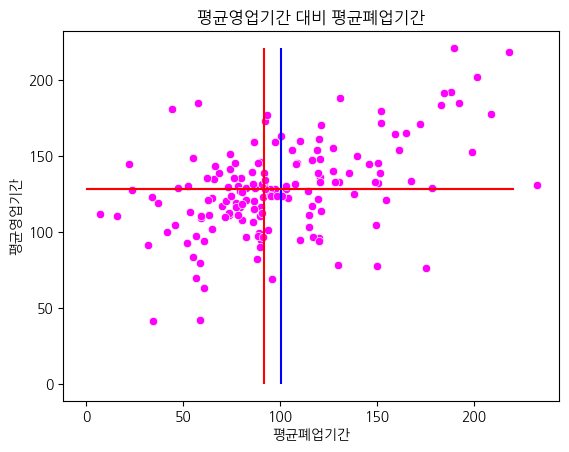

In [57]:
sns.scatterplot(data=clean_data,x='평균폐업기간',y='평균영업기간',color='magenta',palette='deep')
plt.title('평균영업기간 대비 평균폐업기간')
plt.hlines(clean_data['평균영업기간'].mean(),0,clean_data['평균영업기간'].max(),color='blue')
plt.vlines(clean_data['평균폐업기간'].mean(),0,clean_data['평균영업기간'].max(),color='blue')
plt.hlines(clean_data['평균영업기간'].median(),0,clean_data['평균영업기간'].max(),color='red')
plt.vlines(clean_data['평균폐업기간'].median(),0,clean_data['평균영업기간'].max(),color='red')
plt.show()

In [58]:
display(clean_data['평균영업기간'].agg(['mean','median']))
display(clean_data['평균폐업기간'].agg(['mean','median']))

# 평균폐업기간의 경우 중앙값이 더 작다.

mean      128.331549
median    128.085104
Name: 평균영업기간, dtype: float64

mean      100.705573
median     91.812507
Name: 평균폐업기간, dtype: float64

### 5.2.2 상권변화 유형

In [59]:
kind_area = clean_data.copy()

In [60]:
avg_open_period = kind_area['평균영업기간']
avg_close_period = kind_area['평균폐업기간']

# 각 기간의 평균 저장
open_mean = avg_open_period.median()
close_mean = avg_close_period.median()

# kind column 생성
kind_area['KIND'] = ''

# HH : 정체형, 창업 진출입시 세심한 주의 상권
HH = clean_data[(open_mean < avg_open_period) & (close_mean < avg_close_period)]
kind_area.loc[(open_mean < avg_open_period) & (close_mean < avg_close_period),'KIND'] = 'HH'

# HL : 상권축소형, 경쟁력 있는 기존 업체 우위 상권
HL = clean_data[(open_mean < avg_open_period) & (close_mean > avg_close_period)]
kind_area.loc[(open_mean < avg_open_period) & (close_mean > avg_close_period),'KIND'] = 'HL'

# LH : 상권확장형, 경쟁력 있는 신규 창업 우위 상권
LH = clean_data[(open_mean > avg_open_period) & (close_mean < avg_close_period)]
kind_area.loc[(open_mean > avg_open_period) & (close_mean < avg_close_period),'KIND'] = 'LH'

# LL : 다이나믹(순환)형, 도시재생 및 신규 개발상권으로 창업 진출입시 세심한 주의 상권
LL = clean_data[(open_mean > avg_open_period) & (close_mean > avg_close_period)]
kind_area.loc[(open_mean > avg_open_period) & (close_mean > avg_close_period),'KIND'] = 'LL'

kind_list = [HH,HL,LH,LL]
title_list = ['HH','HL','LH','LL']

In [61]:
kind_area.to_csv('../data/전처리 파일/부평구 상권변화 유형.csv',index=False,encoding='euc-kr')

In [62]:
print(('='*15)+' 상권변화 유형별 갯수 '+('='*15))
print('HH : {0}\nHL : {1}\nLH : {2}\nLL : {3}'.format(len(HH),len(HL),len(LH),len(LL)))

=============== 상권변화 유형별 갯수 ===============
HH : 53
HL : 26
LH : 26
LL : 53


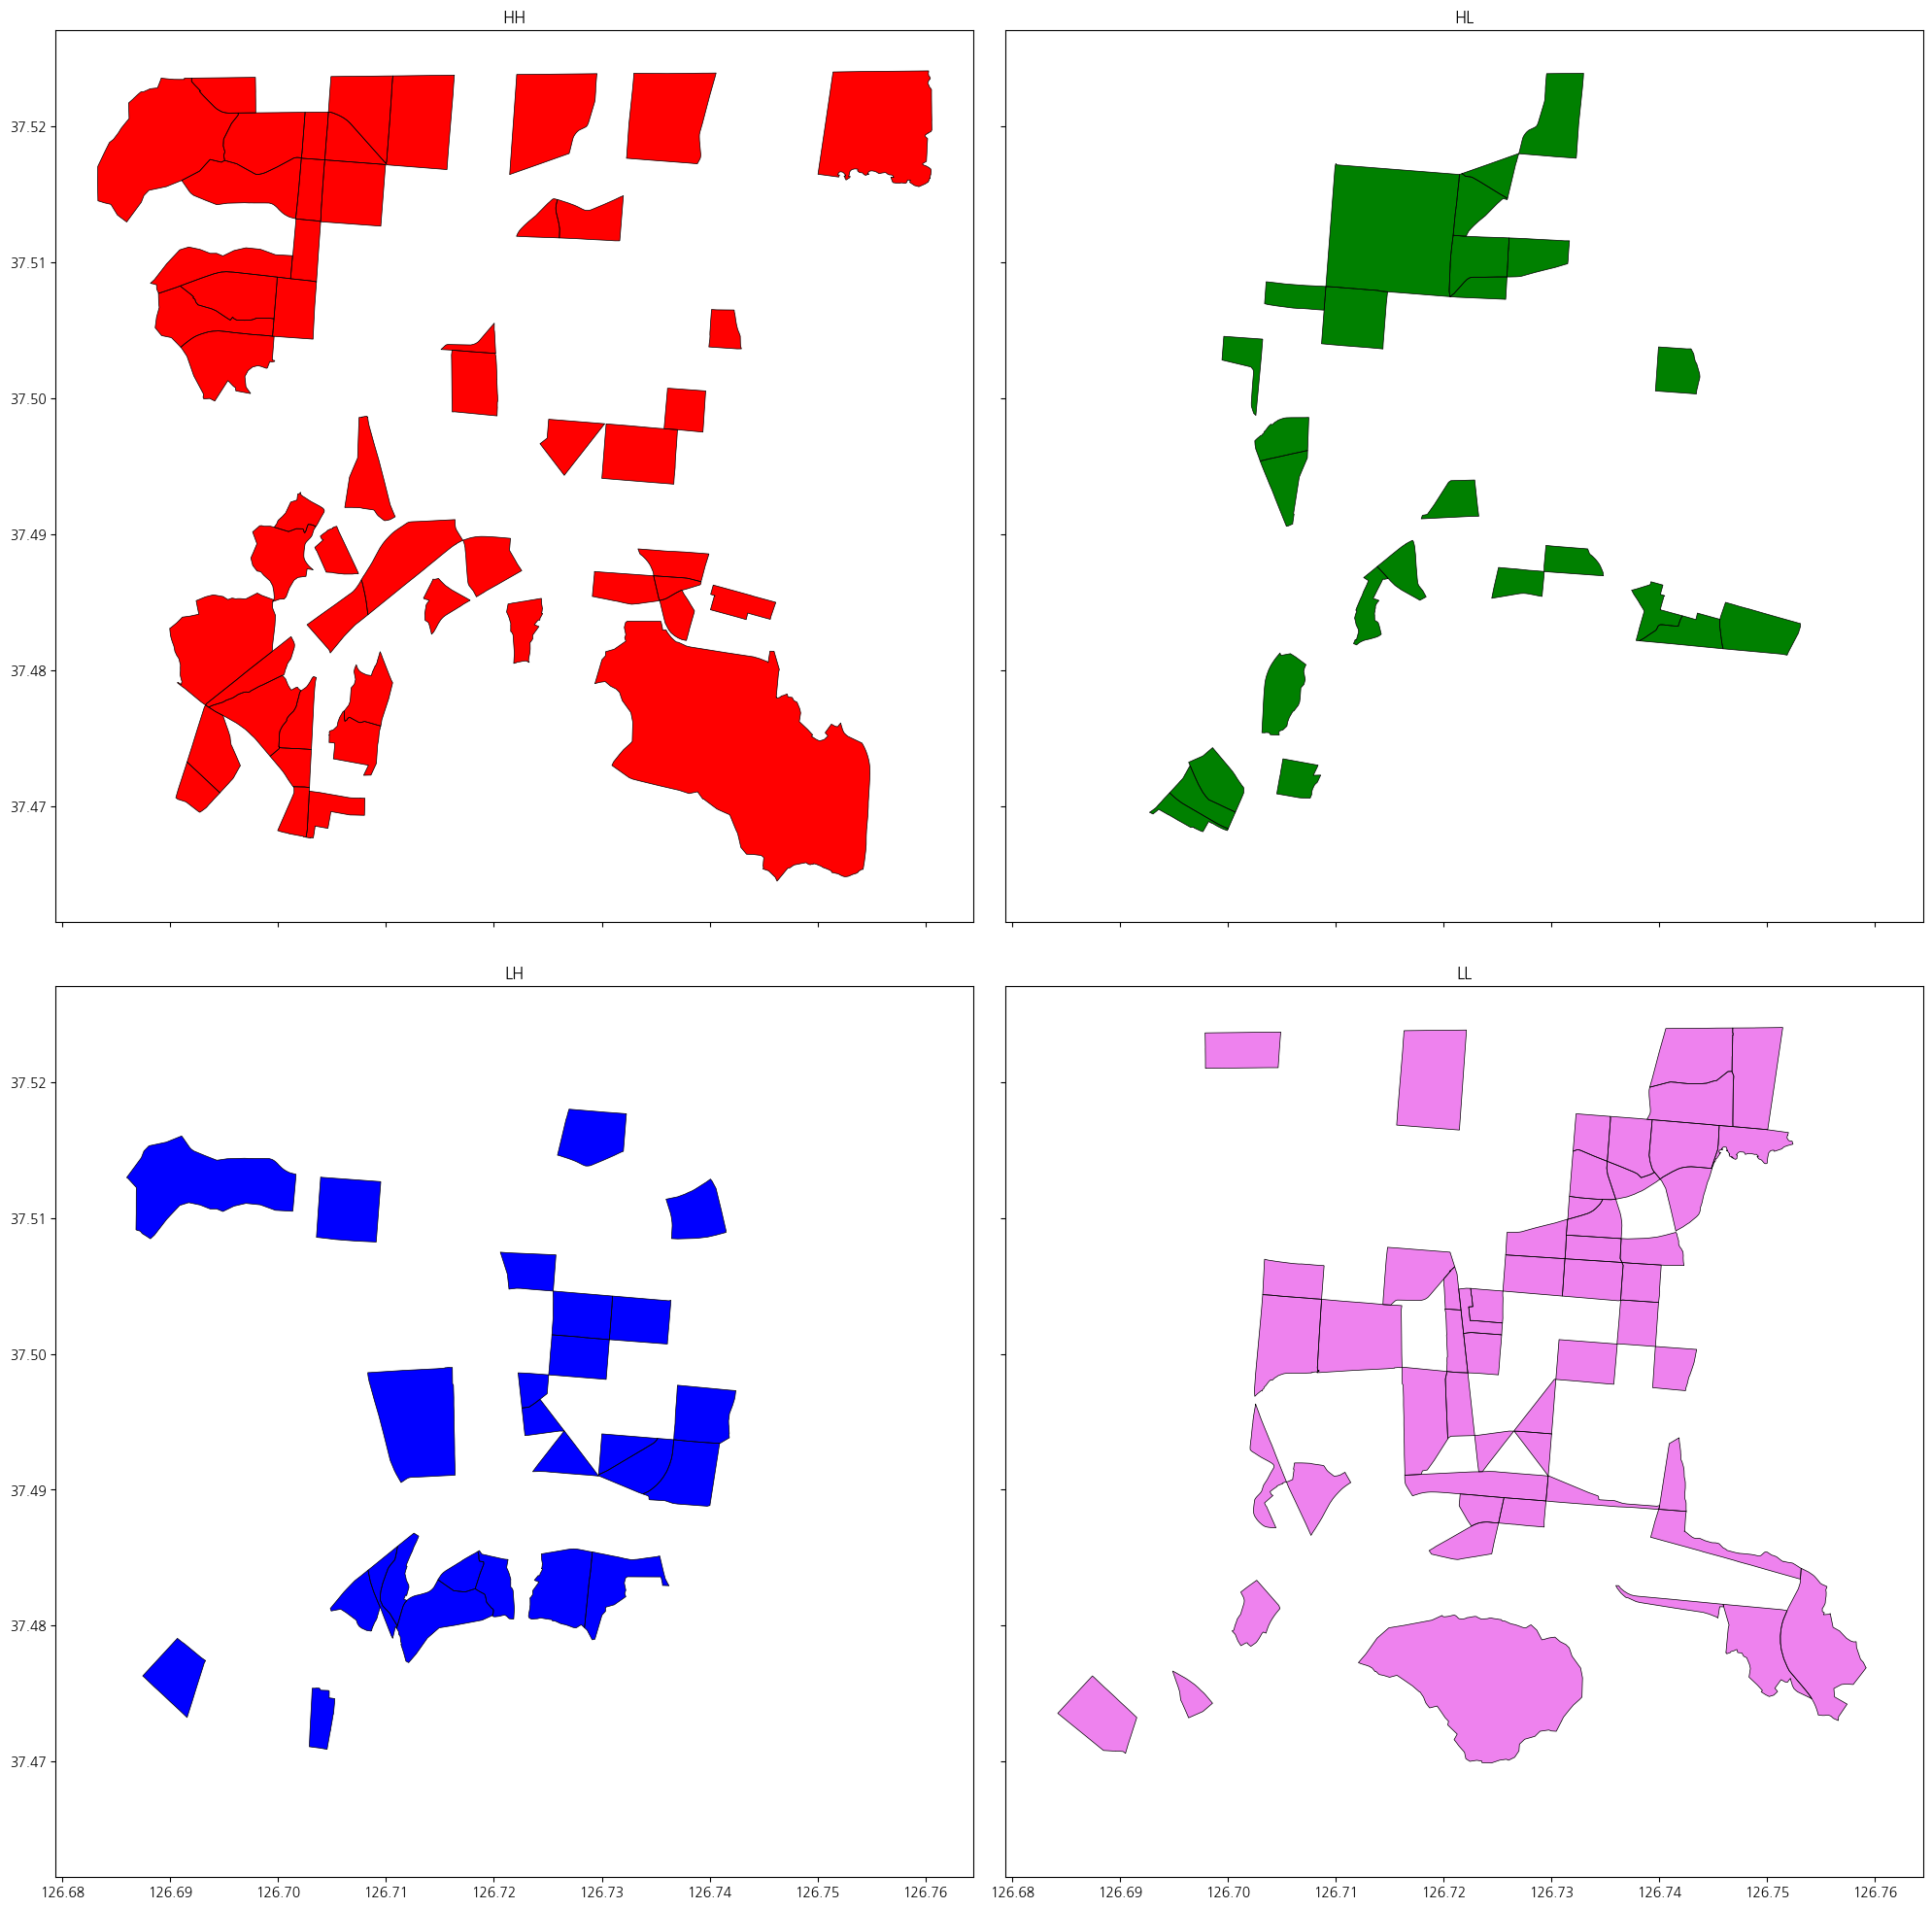

In [63]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(20,20))
colors = ['red','green','blue','violet']
#         HH, HL, LH, LL

for i in range(int(len(kind_list)/2)):
    for j in range(2):
        gdf = gpd.GeoDataFrame(kind_list[2*i+j])
        gdf.plot(ax=axes[i,j],color=colors[2*i+j])
        gdf.boundary.plot(ax=axes[i,j],color='black',linewidth=0.5)
        axes[i,j].set_title(title_list[2*i+j])

plt.tight_layout()
plt.show()

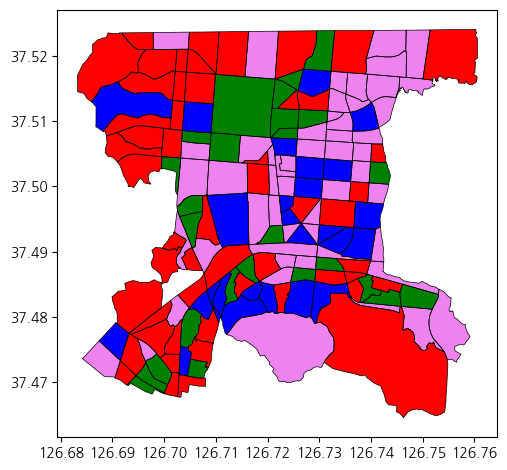

In [64]:
ax = plt.subplot()
colors = ['red','green','blue','violet']
#         HH, HL, LH, LL

for i in range(4):
    gdf = gpd.GeoDataFrame(kind_list[i])
    gdf.plot(ax=ax,color=colors[i])
    gdf.boundary.plot(ax=ax,color='black',linewidth=0.5)

plt.tight_layout()
plt.show()

### 5.2.3 상관관계

#### 5.2.2.1 독립변수와 종속변수간의 상관계수

In [153]:
corr_df = clean_data.iloc[:,ind_var_col+[9]].corr()
corr = corr_df.loc[optimal_feature,'평균영업기간'].sort_values()
corr[abs(corr) > 0.07]

외식업종다양성            -0.345378
평균 도로 길이           -0.213118
점포밀도               -0.164169
BUILD_DIFF_AVG     -0.155611
상가밀도               -0.134432
APART_DIFF_AVG     -0.099813
아파트 가구수            -0.075011
평균최근접정류장거리         -0.071951
공동주택 연면적 비율         0.073420
INT_LOAD            0.093418
(주거인구+직장인구)/유동인구    0.136268
평균최근접역거리            0.277278
단독주택 연면적 비율         0.286487
Name: 평균영업기간, dtype: float64

#### 5.2.2.2 상관 그래프

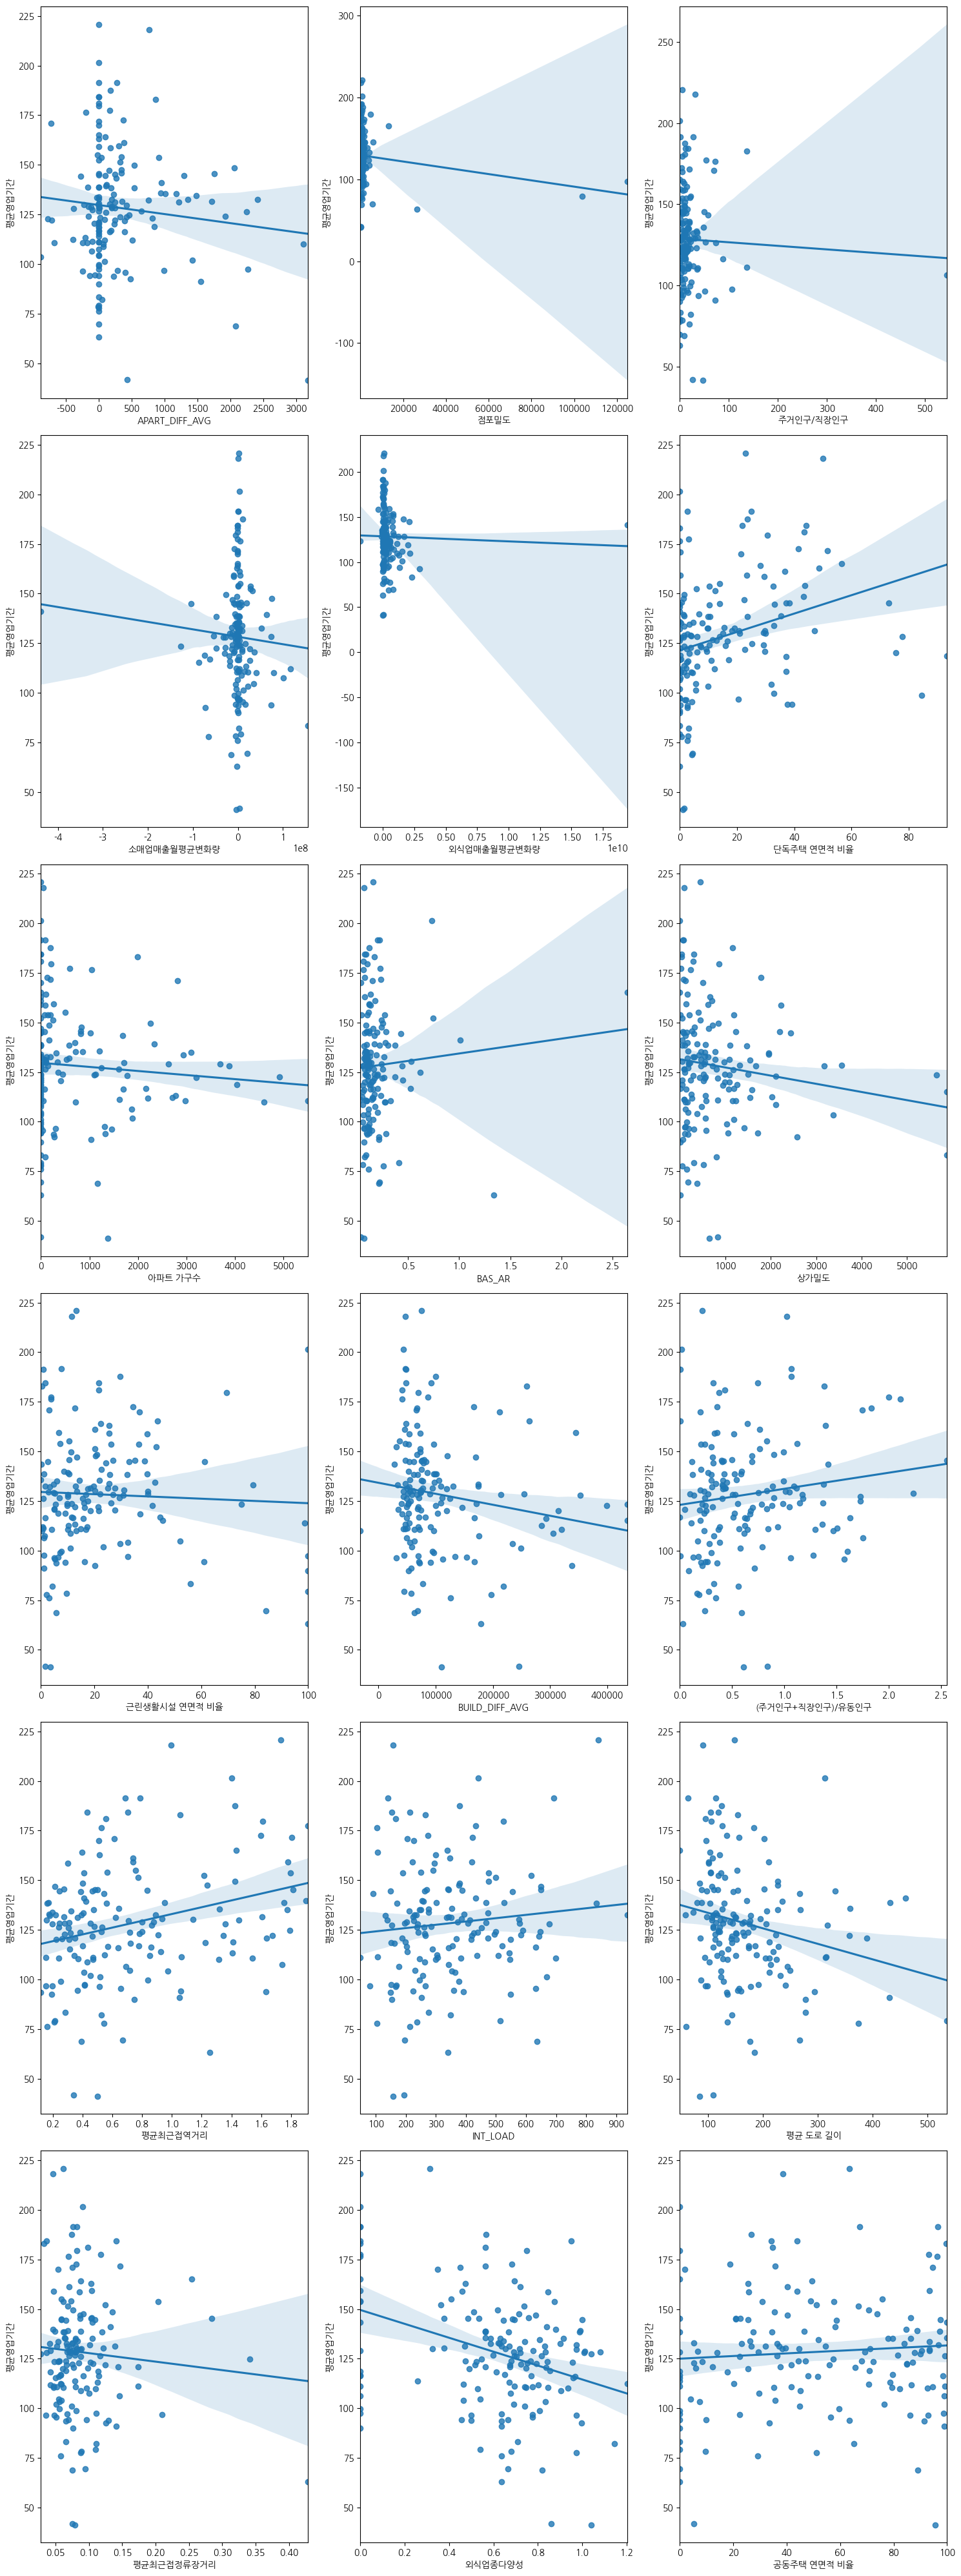

In [136]:
fig, axes = plt.subplots(nrows=int(len(optimal_feature)/3),ncols=3,figsize=(15,40))

for idx, col in enumerate(optimal_feature):
    sns.regplot(x=col,y='평균영업기간',data=clean_data,ax=axes[int(idx/3),idx % 3])

plt.tight_layout()
plt.show()

## 5.2 MODELING

In [76]:
#Calibrate GWR model
# 평균영업기간

gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='bisquare',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='bisquare',spherical=True)
gwr_results = gwr_model.fit()

156.0


In [66]:
gwr_coef_df = pd.DataFrame(gwr_results.params)
gwr_coef_df.columns = ['intercept']+list(dX.columns)
gwr_coef_df['x'] = u
gwr_coef_df['y'] = v
gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
gwr_coef_df.to_csv('../data/전처리 파일/GWR 회귀계수(평균폐업기간).csv',index=False)

In [77]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                    20

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         195736.644
Log-likelihood:                                                    -786.825
AIC:                                                               1613.650
AICc:                                                              1622.444
BIC:                                                             195038.006
R2:                                                                   0.314
Adj. R2:                                                              0.220

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 5.2.1 Scaling

#### 5.2.1.1 왜도 확인

In [78]:
from scipy.stats import skew

skew_val = []

for i, col in enumerate(list(dX)):
#     print('{0}. {1} : {2:.3f}'.format(i+1,col,skew(dX.loc[:,col])))
    skew_val.append(skew(dX.loc[:,col]))

skew_data = pd.DataFrame({'column name': list(dX),'skew':skew_val})

In [79]:
skew_col = skew_data[skew_data['skew'].apply(lambda x : abs(x)) > 2]['column name']
# skew_col
skew_col = skew_col.values
# 이 데이터들의 분포를 살펴보자.

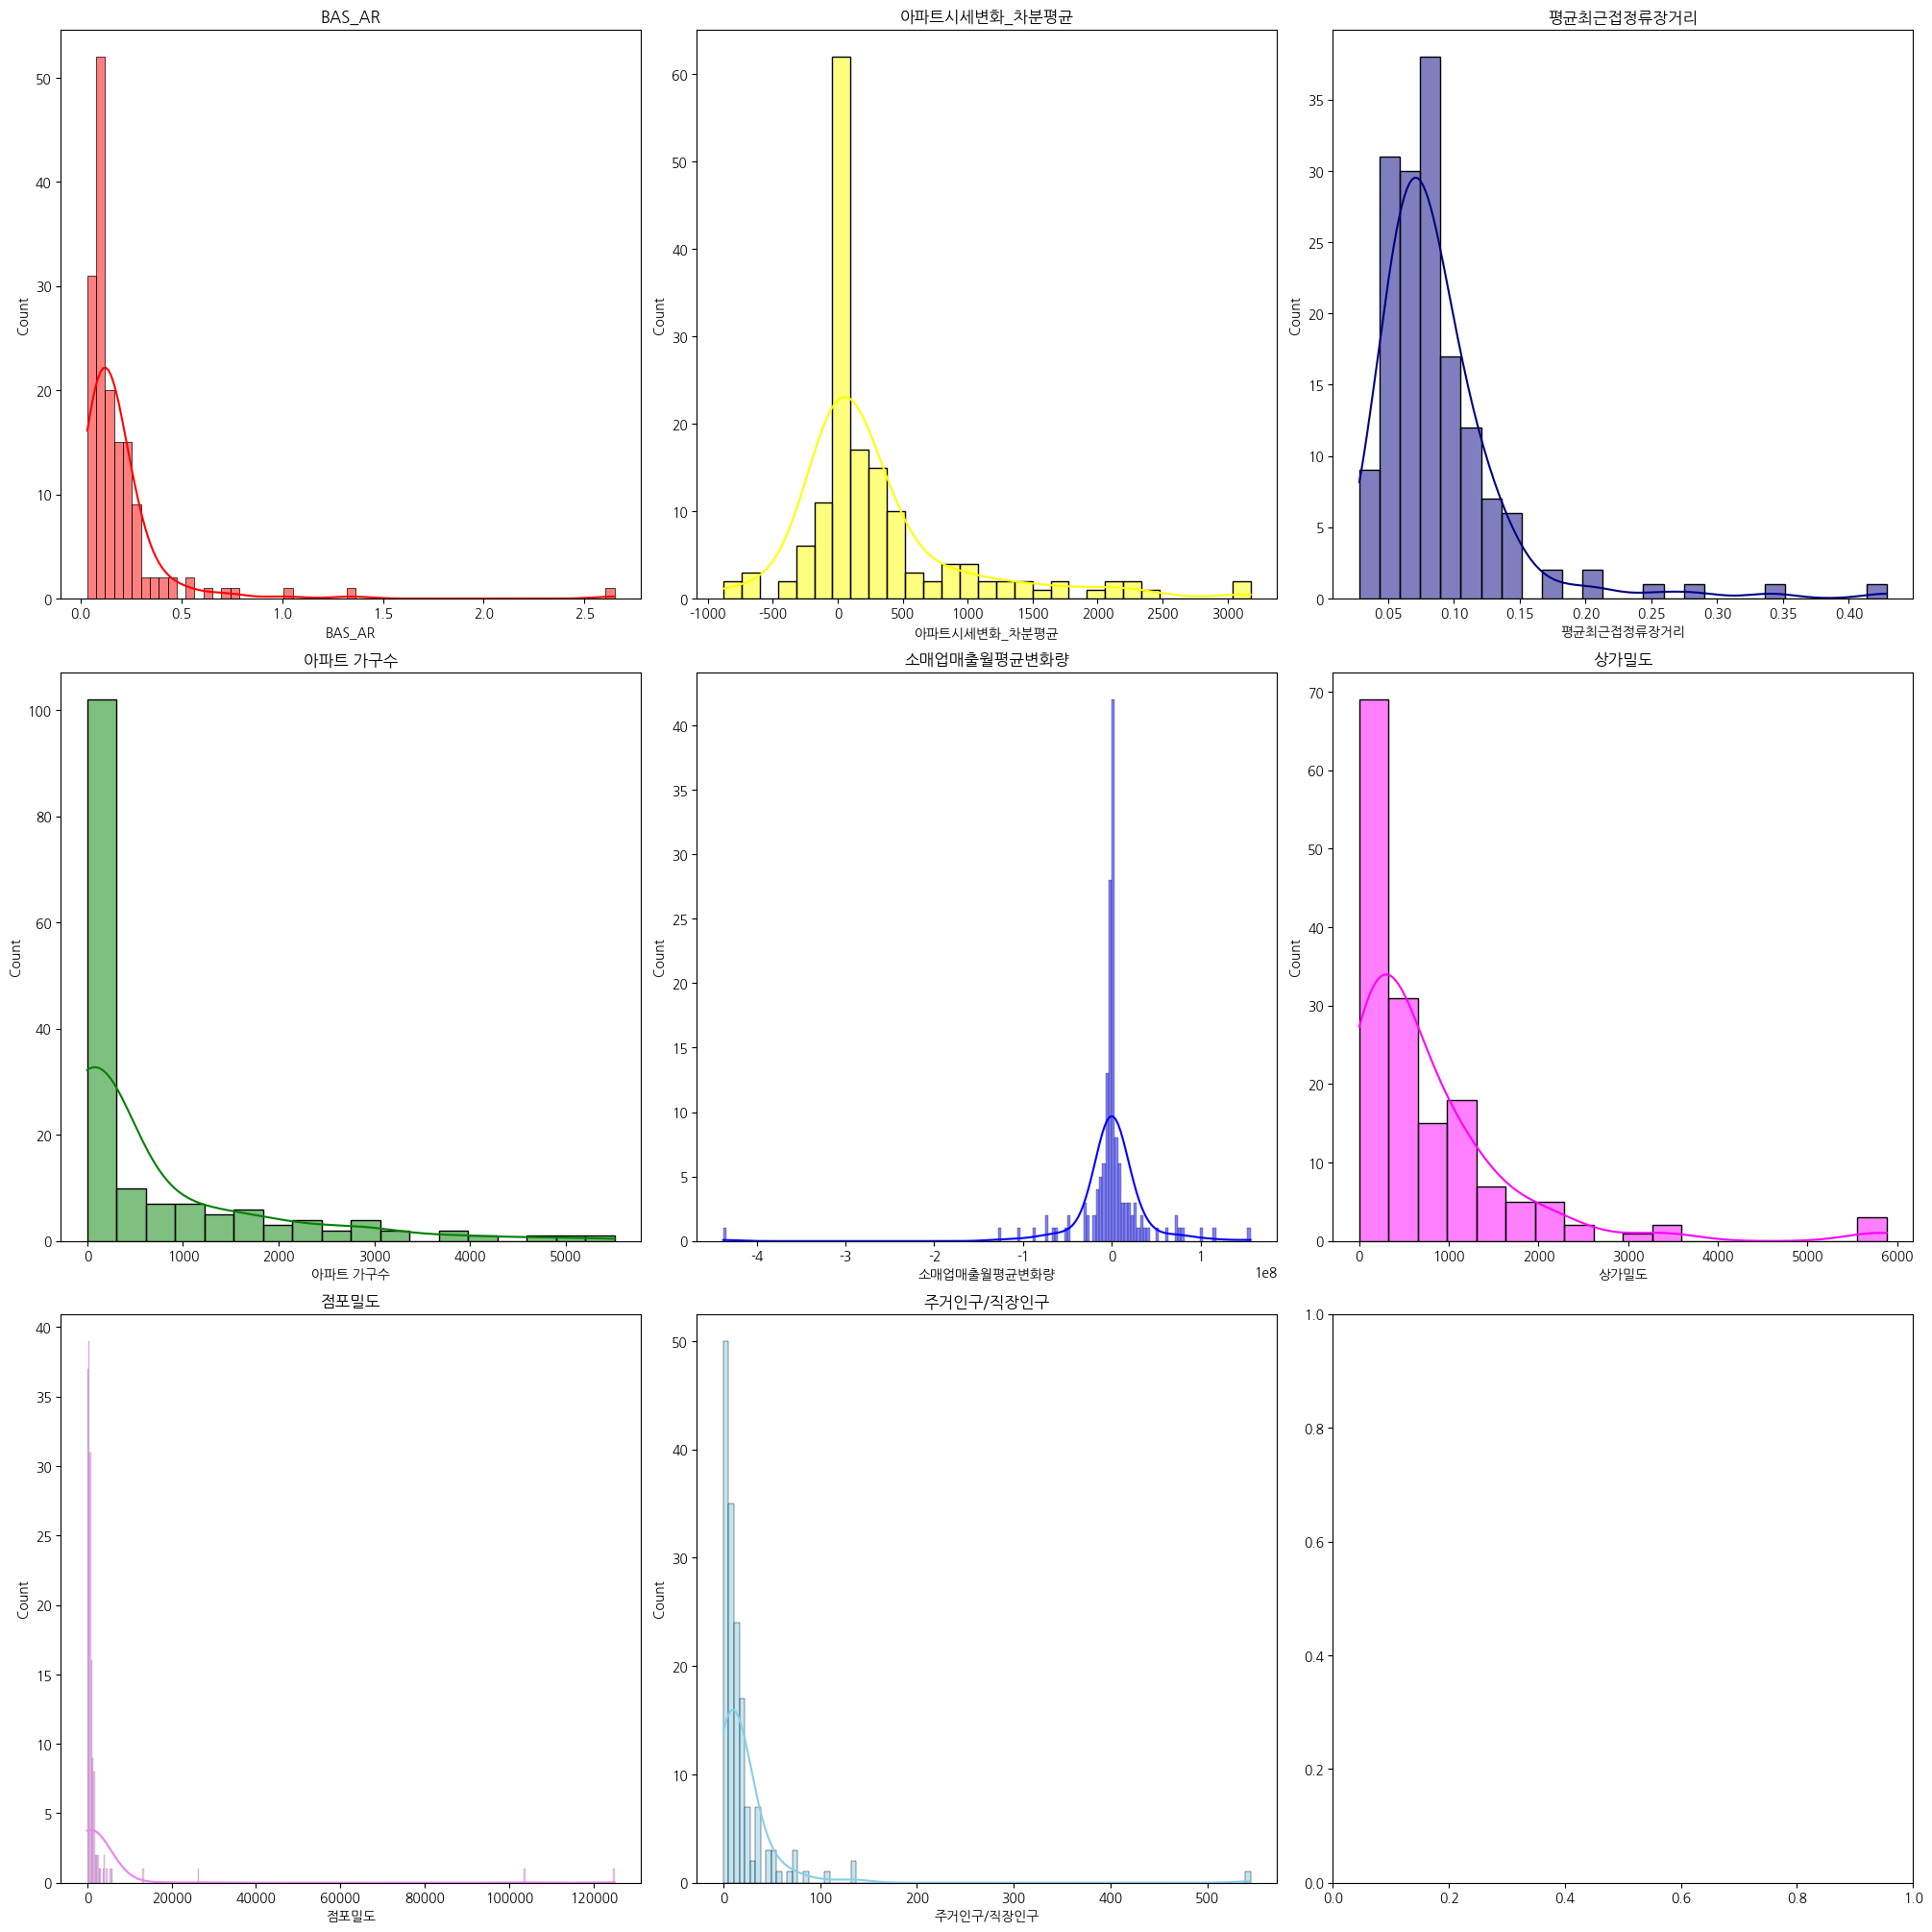

In [80]:
fig, axes = plt.subplots((int(len(skew_col)/3)+1),3,figsize=(20,20),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(int(len(skew_col)/3)+1):
    for j in range(3):
        if (3*i+j) == len(skew_col):
            break
        
        sns.histplot(ax=axes[i,j], data=dX, x=skew_col[(3*i+j)], kde=True,color=color[(3*i+j) % 8])
        axes[i,j].set_title(skew_col[3*i+j])
         
plt.show()

In [81]:
# 해당 컬럼들은 log변환 진행.
log_ok_col = skew_col[[0,2,3,5,6,7]]

scaled_dX = dX.copy()
scaled_dX.loc[:,log_ok_col] = scaled_dX.loc[:,log_ok_col].apply(lambda x : np.log1p(x))

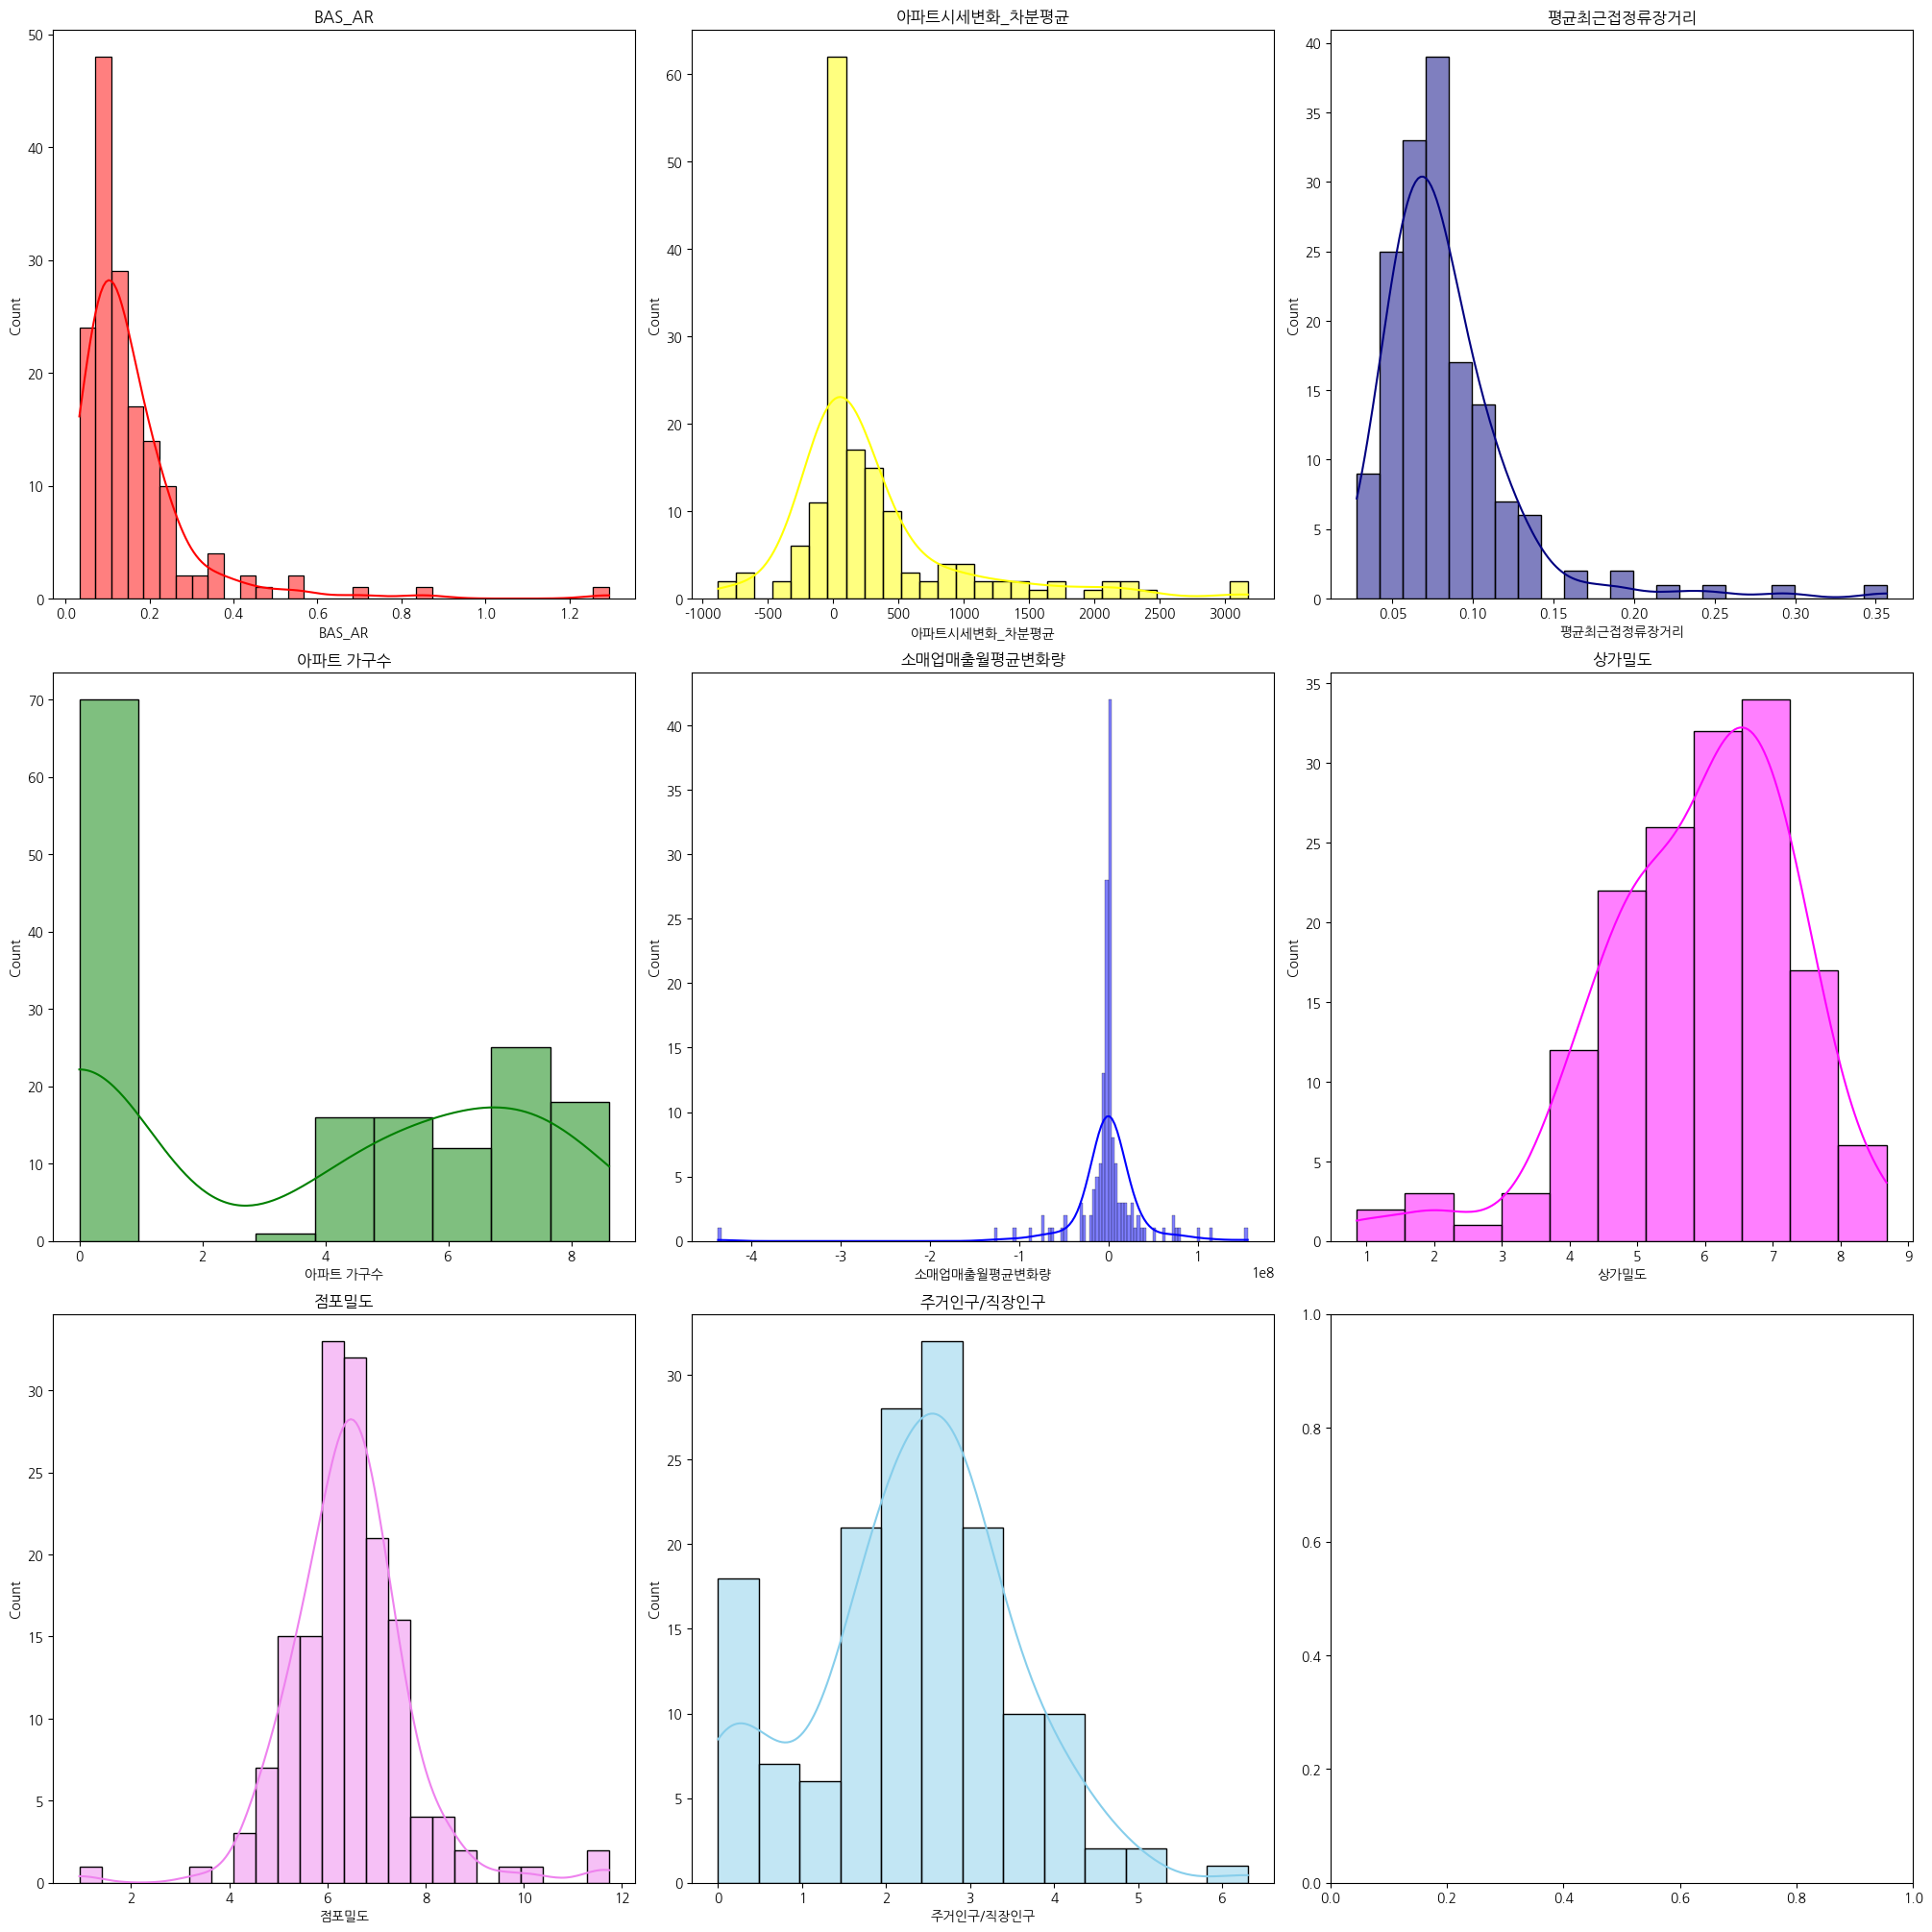

In [82]:
fig, axes = plt.subplots((int(len(skew_col)/3)+1),3,figsize=(20,20),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(int(len(skew_col)/3)+1):
    for j in range(3):
        if (3*i+j) == len(skew_col):
            break
        
        sns.histplot(ax=axes[i,j], data=scaled_dX, x=skew_col[(3*i+j)], kde=True,color=color[(3*i+j) % 8])
        axes[i,j].set_title(skew_col[3*i+j])
        
plt.show()

#### 5.2.1.2 Remodeling

In [84]:
# 스케일링된 독립변수 설정.
s_X = scaled_dX.values

# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='bisquare',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='bisquare',spherical=True)
gwr_results = gwr_model.fit()

157.0


In [85]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                    32

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         440973.044
Log-likelihood:                                                    -850.990
AIC:                                                               1765.979
AICc:                                                              1778.505
BIC:                                                             440335.157
R2:                                                                  -0.545
Adj. R2:                                                             -0.925

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

#### 5.2.1.3 MinMaxScaling
- 교차검증 시 안했을 때의 best score와 같았음.

In [100]:
scaler = MinMaxScaler()
mm_scaled_dX = scaled_dX.copy()
mm_scaled_dX = pd.DataFrame(scaler.fit_transform(mm_scaled_dX),columns=mm_scaled_dX.columns)
s_X = mm_scaled_dX.values

#### 5.2.1.4 Remodeling

In [105]:
# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='bisquare',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='bisquare',spherical=True)
gwr_results = gwr_model.fit()

157.0


In [106]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                    32

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         147071.273
Log-likelihood:                                                    -764.242
AIC:                                                               1592.485
AICc:                                                              1609.378
BIC:                                                             146433.386
R2:                                                                   0.485
Adj. R2:                                                              0.358

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

#### 5.2.1.5 Standard Scaling

In [113]:
scaler = StandardScaler()
ss_scaled_dX = scaled_dX.copy()
ss_scaled_dX = pd.DataFrame(scaler.fit_transform(ss_scaled_dX),columns=ss_scaled_dX.columns)
s_X = ss_scaled_dX.values

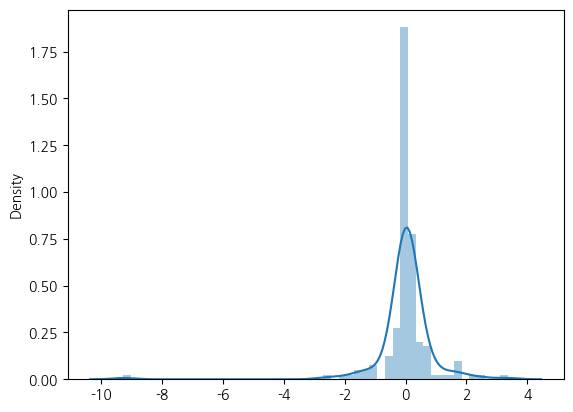

In [104]:
sns.distplot(x=ss_scaled_dX['소매업매출월평균변화량'])
plt.show()

#### 5.2.1.6 Remodeling

In [114]:
# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='bisquare',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='bisquare',spherical=True)
gwr_results = gwr_model.fit()

157.0


In [115]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                    32

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         147071.273
Log-likelihood:                                                    -764.242
AIC:                                                               1592.485
AICc:                                                              1609.378
BIC:                                                             146433.386
R2:                                                                   0.485
Adj. R2:                                                              0.358

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 5.2.2 교차검증

In [63]:
def cross_validation_gwr(lX, ly, kernel,ran_state):
    train_aic = np.zeros(5)
    train_ll = np.zeros(5)
    train_r2 = np.zeros(5)
    test_r2 = np.zeros(5)

    cv = KFold(5, shuffle=True, random_state=ran_state)

    for i, (idx_train, idx_test) in enumerate(cv.split(X = lX, y = ly)):
    
#         print('====================== FOLD {} ======================'.format(i))
        # train, test split
        local_X_train, local_y_train = lX[idx_train], ly[idx_train]
        local_u_train = clean_data.iloc[idx_train]['x']
        local_v_train = clean_data.iloc[idx_train]['y']
        local_train_coords = list(zip(local_u_train,local_v_train))
    
        local_X_test, local_y_test = lX[idx_test], ly[idx_test]
        local_u_test = clean_data.iloc[idx_test]['x']
        local_v_test = clean_data.iloc[idx_test]['y']
        local_test_coords = list(zip(local_u_test,local_v_test))
    
        # 모델 생성
        gwr_selector = Sel_BW(local_train_coords, local_y_train, local_X_train,kernel=kernel,spherical=True)
        gwr_bw = gwr_selector.search(bw_min=2)
#         print('BAND WIDTH : {}'.format(gwr_bw))
        gwr_model = GWR(local_train_coords, local_y_train, local_X_train, gwr_bw,kernel=kernel,spherical=True)
        gwr_results = gwr_model.fit()
    
        # Prediction
        scale = gwr_results.scale
        residuals = gwr_results.resid_response
        pred_results = gwr_model.predict(np.array(local_test_coords), local_X_test, scale, residuals)
        pred = pred_results.predictions.flatten()
    
        # AIC
        train_aic[i] = gwr_results.aic
    
        # R2 스코어
        train_r2[i] = gwr_results.R2
        test_r2[i] = r2_score(local_y_test,pred)
    
        # Log-Likelihood
        train_ll[i] = gwr_results.llf
    
#         train_rmse[i] = np.sqrt(gwr_results.mse_model)
#         test_rmse[i] = np.sqrt(mean_squared_error(local_y_test,pred))
    
#         print('TRAIN R2 : {:.8f}, TEST R2 : {:.8f}'.format(train_r2[i], test_r2[i]))
#         print('TRAIN RMSE : {:.8f}, TEST RMSE : {:.8f}'.format(train_rmse[i], test_rmse[i]))
#         print("TRAIN AIC : {:.8f}".format(train_aic[i]))
#         print("TRAIN LOG-LIKELIHOOD : {:.8f}".format(train_ll[i]))
    
#     print('\n===================== 평균 결과 ======================')
#     print('TRAIN R2 : {:.8f}, TEST R2 : {:.8f}'.format(train_r2.mean(), test_r2.mean()))
#     print('TRAIN RMSE : {:.8f}, TEST RMSE : {:.8f}'.format(train_rmse.mean(), test_rmse.mean()))
#     print("TRAIN AIC : {:.8f}".format(train_aic.mean()))
#     print("TRAIN LOG-LIKELIHOOD : {:.8f}".format(train_ll.mean()))
    
    return train_aic.mean(), train_ll.mean()

# cross_validation_gwr(s_X, s_y1)

### 5.2.3 Feature Selection

In [64]:
def search_best_model(kernel,ind_val,ran_state,i):
    flag = True
    min_aic = float('inf')
    max_ll = float('-inf')
    col_list = list(ind_val.columns)
    drop_col = []

    # flag가 False라면 탈출
    while flag :  
        # 조건 초기화, 평가 치표가 업데이트 된 흔적이 있으면 다시 진입할 것이다.
        flag = False 
    
        # 사용 컬럼 업데이트
#         print('COL LIST COUNT : {}'.format(len(col_list)-len(drop_col)))
#         print('DROP COLUMN LIST COUNT : {}'.format(len(drop_col)))
        col_list = list(set(col_list) - set(drop_col))
        drop_col.clear()
    
        # 사용할 독립변수 업데이트
        temp_dX = ind_val.loc[:,col_list]
    
        # 컬럼 하나씩 지우면서 평가지표 확인
#         for col in tqdm_notebook(col_list):
        for col in col_list:
            local_X = temp_dX.drop(col,axis=1).values
            new_aic, new_ll = cross_validation_gwr(local_X, s_y2,kernel,ran_state)
        
            # 새로운 aic는 기존의 aic보다 작고, 새로운 ll은 기존의 ll보다 큰가?(AND 조건이어야 함.)
            if (new_aic < min_aic) & (new_ll > max_ll):
                min_aic = new_aic
                max_ll = new_ll
                drop_col.append(col)
                flag = True
#                 print('========================= NEW VALIDATION =========================')
#                 print('NEW MIN AIC : {:.8f}'.format(min_aic))
#                 print('NEW MAX LOG-LIKELIHOOD : {:.8f}'.format(max_ll))

    # 다중공선성 제거 유무
    remove = 'O' if i == 0 else 'X'
    
    print('========================= RESULT =========================')
    print('KERNEL : {}'.format(kernel))
    print('RANDOM STATE : {}'.format(ran_state))
    print('다중공선성 제거 유무 : {}'.format(remove))
    print('MIN AIC : {:.8f}'.format(min_aic))
    print('MAX LOG-LIKELIHOOD : {:.8f}'.format(max_ll))
    print('COLUMN COUNT : {}'.format(len(col_list)))
#     print('COLUMN : {}'.format(col_list))

    
    result = pd.DataFrame({'KERNEL':kernel,'RANDOM STATE':ran_state,'다중공선성 제거 유무':remove,'AIC':min_aic
                  ,'LOG LIKELIHOOD':max_ll,'COLUMN COUNT':len(col_list),'COLUMN':[col_list]})
    
    return result

In [116]:
# Not Scaled Data
# remove_vif_dX = dX.loc[:,optimal_feature].copy() # 다중공선성 제거
# not_remove_vif_dX = dX.copy() # 다중공선성 제거 X

# Scaled Data
remove_vif_dX = ss_scaled_dX.loc[:,optimal_feature].copy() # 다중공선성 제거
not_remove_vif_dX = ss_scaled_dX.copy() # 다중공선성 제거 X

list_df = [remove_vif_dX,not_remove_vif_dX]
kernel = ['gaussian','bisquare','exponential']
random_state = [10,50,100,500,1000]

conclusion = pd.DataFrame()
count = 0

for k in kernel:
    for i, df in enumerate(list_df):
        for rs in random_state:
            result = search_best_model(k,df,rs,i)
            conclusion= pd.concat([conclusion,result],axis=0,ignore_index=True)
            count += 1
            print('진행률 : {:.2f}%'.format(count/(len(kernel)*len(list_df)*len(random_state))*100))         

conclusion.head()

========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 10
다중공선성 제거 유무 : O
MIN AIC : 1285.12815676
MAX LOG-LIKELIHOOD : -619.77806181
COLUMN COUNT : 15
진행률 : 3.33%
========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 50
다중공선성 제거 유무 : O
MIN AIC : 1285.25604496
MAX LOG-LIKELIHOOD : -619.86260426
COLUMN COUNT : 15
진행률 : 6.67%
========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 100
다중공선성 제거 유무 : O
MIN AIC : 1285.50185140
MAX LOG-LIKELIHOOD : -619.84155428
COLUMN COUNT : 15
진행률 : 10.00%
========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 500
다중공선성 제거 유무 : O
MIN AIC : 1285.35473746
MAX LOG-LIKELIHOOD : -619.64628102
COLUMN COUNT : 16
진행률 : 13.33%
========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 1000
다중공선성 제거 유무 : O
MIN AIC : 1284.97572007
MAX LOG-LIKELIHOOD : -619.65730715
COLUMN COUNT : 14
진행률 : 

,KERNEL,RANDOM STATE,다중공선성 제거 유무,AIC,LOG LIKELIHOOD,COLUMN COUNT,COLUMN
0,gaussian,10,O,1285.128157,-619.778062,15,"[서비스업매출월평균변화량, 공동주택 연면적 비율, 도로길이고려_국부통합도_R3, 아..."
1,gaussian,50,O,1285.256045,-619.862604,15,"[서비스업매출월평균변화량, 공동주택 연면적 비율, 도로길이고려_국부통합도_R3, 아..."
2,gaussian,100,O,1285.501851,-619.841554,15,"[서비스업매출월평균변화량, 공동주택 연면적 비율, 도로길이고려_국부통합도_R3, 아..."
3,gaussian,500,O,1285.354737,-619.646281,16,"[도로길이고려_국부통합도_R3, 상가밀도, 단독주택 연면적 비율, (주거인구+직장인..."
4,gaussian,1000,O,1284.975720,-619.657307,14,"[서비스업매출월평균변화량, 도로길이고려_국부통합도_R3, 아파트시세변화_차분평균, ..."


In [68]:
condition = (conclusion['AIC'] == conclusion['AIC'].min()) | (conclusion['LOG LIKELIHOOD'].max() == conclusion['LOG LIKELIHOOD'])
conclusion[condition]

,KERNEL,RANDOM STATE,다중공선성 제거 유무,AIC,LOG LIKELIHOOD,COLUMN COUNT,COLUMN
18,bisquare,500,X,1263.451518,-584.866515,27,"[소매업매출월평균변화량, 기초구역평균_국부통합도_R3, 도로길이고려_전체통합도, 건..."
19,bisquare,1000,X,1266.262801,-584.424806,27,"[소매업매출월평균변화량, 도로길이고려_전체통합도, 기초구역평균_국부통합도_R3, 건..."


In [77]:
conclusion.to_csv('../data/최적모델평가지표(평균폐업기간).csv',encoding='euc-kr',index=False)

#### 5.2.3.1 Remodeling
- 위의 검증 결과 중 가장 좋은 모델 성능을 보이는 컬럼을 기준으로 모델을 돌려본다.

In [69]:
# kernel : bisquare
# 다중공선성 제거 X

col = conclusion.iloc[18]['COLUMN']

s_X = dX.loc[:,col].values

In [70]:
gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='bisquare',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='bisquare',spherical=True)
gwr_results = gwr_model.fit()

157.0


In [ ]:
gwr_coef_df = pd.DataFrame(gwr_results.params)
gwr_coef_df.columns = ['intercept']+col
gwr_coef_df['x'] = u
gwr_coef_df['y'] = v
gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
gwr_coef_df.to_csv('../data/전처리 파일/GWR 회귀계수(평균폐업기간,BEST).csv',encoding='euc-kr',index=False)

In [71]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                    28

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         640771.732
Log-likelihood:                                                    -880.511
AIC:                                                               1817.022
AICc:                                                              1830.499
BIC:                                                             640113.594
R2:                                                                  -1.244
Adj. R2:                                                             -1.710

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

# 6. 군집별 회귀분석

## 6.1 군집 데이터 로딩

In [ ]:
sds_cluster = pd.read_csv('../data/군집화 결과/sds_cluster.csv')
sds_cluster.head()

In [ ]:
sds_cluster['BAS_ID']= sds_cluster['BAS_ID'].astype(str)

1. 각 클러스터 기준에 따라서, 각 군집별로 회귀 모델을 생성.
2. 각 모델별로 회귀계수 dataframe 생성

## 6.2 평균영업기간(7개 군집)

In [ ]:
temp_df = sds_cluster[['BAS_ID','open_7cluster_sds']]
open_cluster_7 = clean_data.merge(temp_df,how='inner',right_on='BAS_ID',left_on='BAS_ID')

## 6.3 군집별 GWR 모델링

In [ ]:
ind_var_col = list(range(1,9)) + list(range(11,34))

s_y1 = clean_data['평균영업기간'].values.reshape((-1,1)) # 종속변수1
s_y2 = clean_data['평균폐업기간'].values.reshape((-1,1)) # 종속변수2
# s_X = clean_data.iloc[:,ind_var_col].drop(scale_factor,axis=1).values # 다중공선성이 있는 column들은 제거
s_X = clean_data.iloc[:,ind_var_col].values
u = clean_data['x'] # 경도
v = clean_data['y'] # 위도
s_coords = list(zip(u,v))

s_X.shape

### 6.3.1 종속변수, 독립변수 설정

In [ ]:
# 독립변수, 종속변수 설정
# 이전에 모델 생성에 있어서 가장 성능이 좋았던 컬럼들을 이용하자.
s_X = pd.concat([open_cluster_7.iloc[:,ind_var_col],open_cluster_7.loc[:,'open_7cluster_sds']],axis=1)
s_X = s_X
s_y1 = open_cluster_7['평균폐업기간'].values.reshape((-1,1))
u = open_cluster_7['x'] # 경도
v = open_cluster_7['y'] # 위도
s_coords = list(zip(u,v))

### 6.3.2 군집별 모델 생성

In [ ]:
# 군집 리스트 생성
cluster_list = open_cluster_7['open_7cluster_sds'].unique()

# 군집별 모델 생성
for cluster in cluster_list:
    

# 7. T-검정

In [94]:
# 필요 데이터셋 생성
s_X = pd.concat([dX.loc[:,col],clean_data.loc[:,['x','y']]],axis=1)

# train, test split
X_train, X_test, y_train, y_test = train_test_split(s_X, s_y2, test_size=0.2, shuffle=True,random_state=34)

# train 좌표 생성
u_train = X_train.loc[:,'x']
v_train = X_train.loc[:,'y']
train_coords = list(zip(u_train,v_train))

# test 좌표 생성
u_test = X_test.loc[:,'x']
v_test = X_test.loc[:,'y']
test_coords = list(zip(u_test,v_test))

# train, test set 독립변수 리스트에서 좌표 제거
X_train.drop(['x','y'],axis=1,inplace=True)
X_test.drop(['x','y'],axis=1,inplace=True)

X_train = X_train.values
X_test = X_test.values

# 모델 생성
gwr_selector = Sel_BW(train_coords, y_train, X_train,kernel='gaussian')
gwr_bw = gwr_selector.search(bw_min=2)

print('BAND WIDTH : {}'.format(gwr_bw))
gwr_model = GWR(train_coords, y_train, X_train, gwr_bw,kernel='gaussian')
gwr_results = gwr_model.fit()
    
# Prediction
scale = gwr_results.scale
residuals = gwr_results.resid_response
pred_results = gwr_model.predict(np.array(test_coords), X_test, scale, residuals)
pred = pred_results.predictions.flatten() 

BAND WIDTH : 56.0


In [96]:
# 독립이표본 t-test
result = stats.ttest_ind(pred, y_test, equal_var=False)
print('p-value : {:8f}'.format(result[1][0]))

# 유의 수준 0.05에서 귀무가설을 기각할 수 없으므로 두 집단 간의 평균 차이가 없다고 말할 수 있다.

p-value : 0.828207
